# Results: Research Question 2

### Libraries

In [9]:
# Get Packages & Libraries
library(tidyverse)
library(rethinking)
library(stargazer)
library(mice)
library(brms)

### Functions

In [14]:
# Converts all factors to character class
unfactorize <- function(df){
  for(i in which(sapply(df, class) == "factor")) df[[i]] = as.character(df[[i]])
  return(df)
}
# Code from user "By0" at https://stackoverflow.com/questions/2851015/convert-data-frame-columns-from-factors-to-characters (line 14)

In [79]:
# Converts character to factor class
factorizeCharacter <- function(df){
  for(i in which(sapply(df, class) == "character")) df[[i]] = as.factor(df[[i]])
  return(df)
}

In [80]:
# Converts logical to factor class
factorizeLogical <- function(df){
  for(i in which(sapply(df, class) == "logical")) df[[i]] = as.factor(df[[i]])
  return(df)
}

In [90]:
# Converts integer to numeric class
numerize <- function(df){
  for(i in which(sapply(df, class) == "integer")) df[[i]] = as.numeric(df[[i]])
  return(df)
}

In [99]:
# Converts logical to numeric class
numerizeLogical <- function(df){
  for(i in which(sapply(df, class) == "logical")) df[[i]] = as.numeric(df[[i]])
  return(df)
}

### Data

In [191]:
# Get Data
df  <- read.csv("20210130_AM_Data-Letter.csv")

In [192]:
# View Data
glimpse(df)

Rows: 915
Columns: 58
$ X                       <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…
$ docsequence             <int> 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3…
$ docid                   <fct> S10003-D023, S10003-D024, S10003-D025, S10003…
$ docyear                 <int> 1836, 1836, 1837, 1837, 1838, 1838, 1838, 183…
$ doctype                 <fct> Letter, Letter, Letter, Letter, Letter, Lette…
$ allsubject              <fct> "Childbirth; Church attendance; Cities; Farms…
$ broadsubj               <fct> Health; Religion; Communities; Relationships;…
$ personalevent           <fct> NA, NA, NA, NA, NA, NA, NA, NA, Physical illn…
$ wwritten                <fct> "Baltimore, MD; Maryland; United States; Mid-…
$ docauthorid             <fct> per0022938, per0022938, per0022938, per002293…
$ docauthorname           <fct> "Bruns, Jette, 1813-1899", "Bruns, Jette, 181…
$ language                <fct> English; German, English; German, English; Ge…
$ editor                  <fct

In [193]:
vars  <- c("Agricultural",
            "Industrial",
            "Commercial",
            "Professional",
            "Domestic",
            "Social",
            "Government",
            "letterOrphan",
            "letterLast"
           )

In [194]:
df[vars]  <- factorizeLogical(df[vars])
glimpse(df)

Rows: 915
Columns: 58
$ X                       <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…
$ docsequence             <int> 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3…
$ docid                   <fct> S10003-D023, S10003-D024, S10003-D025, S10003…
$ docyear                 <int> 1836, 1836, 1837, 1837, 1838, 1838, 1838, 183…
$ doctype                 <fct> Letter, Letter, Letter, Letter, Letter, Lette…
$ allsubject              <fct> "Childbirth; Church attendance; Cities; Farms…
$ broadsubj               <fct> Health; Religion; Communities; Relationships;…
$ personalevent           <fct> NA, NA, NA, NA, NA, NA, NA, NA, Physical illn…
$ wwritten                <fct> "Baltimore, MD; Maryland; United States; Mid-…
$ docauthorid             <fct> per0022938, per0022938, per0022938, per002293…
$ docauthorname           <fct> "Bruns, Jette, 1813-1899", "Bruns, Jette, 181…
$ language                <fct> English; German, English; German, English; Ge…
$ editor                  <fct

In [195]:
# Get Variables of Interest
df <- df%>%
select("docid",
            "docyear",
            "docauthorid", 
            "sinceMigration", 
            "stayednorthamerica.x", 
            "agewriting", 
            "authorgender", 
            "religionNew", 
            "nationalOrigin", 
            "authorLocation", 
            "Agricultural",
            "Industrial",
            "Commercial",
            "Professional",
            "Domestic",
            "Social",
            "Government",
            "letterOrphan",
            "letterLast",
            "topicNumber",
            "SentimentLTR"
           )

In [160]:
df <- factorizeCharacter(df)

In [166]:
df$authorgender  <- as.integer(df$authorgender)

In [171]:
df$authorgender  <- as.numeric(df$authorgender)

In [175]:
df <- numerize(df)

Data is missing for docyear (8), sinceMigration (263), stayednorthamerica (179), agewriting (234), religionNew (270), nationalOrigin (14), all the occupational classes (151), letterOrphan (164) and letterLast (164).

This data is not missing completely at random (MCAR). Therefore, dropping cases from the analysis would introduce bias and in some cases lead to sparse data. For this reason, we will impute values using MICE. 

We need to be careful about what variables to include as predictor variables. MICE uses all available variable. With this in mind, we need to consider whether we should include all of the above in the imputed dataset. 

These are some factors that researchers have suggested would lead to surivorship bias in the letter collection: recipient interests and mobility (Erickson); editorial influence and purpose as financial record (Benton); age, gender, religion, agrarian, education, wealth and occupation (Helbich & Kamphoefner, 2006).

The above suggests that topicNumber (0), nationalOrigin (14), agewriting (234), authorgender (0), religionNew (270), occupation (164) and SentimentLTR (0) may help predict missing values or why those values are missing. 

Code adapted from https://datascienceplus.com/handling-missing-data-with-mice-package-a-simple-approach/

In [196]:
str(df)

'data.frame':	915 obs. of  21 variables:
 $ docid               : Factor w/ 915 levels "S10003-D023",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ docyear             : int  1836 1836 1837 1837 1838 1838 1838 1839 1839 1839 ...
 $ docauthorid         : Factor w/ 218 levels "per0000238","per0000624",..: 18 18 18 18 18 18 18 18 18 18 ...
 $ sinceMigration      : int  0 0 1 1 2 2 2 3 3 3 ...
 $ stayednorthamerica.x: Factor w/ 2 levels "Left","Stayed": 2 2 2 2 2 2 2 2 2 2 ...
 $ agewriting          : int  23 23 24 24 25 25 25 26 26 26 ...
 $ authorgender        : Factor w/ 2 levels "F","M": 1 1 1 1 1 1 1 1 1 1 ...
 $ religionNew         : Factor w/ 5 levels "Catholic","Christian",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ nationalOrigin      : Factor w/ 18 levels "Czech","Dushane; Xhosa",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ authorLocation      : Factor w/ 3 levels "Canada","Other",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Agricultural        : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 1 1 1 1 ...
 $ Industrial          : Facto

In [177]:
summary(df)

         docid        docyear         docauthorid  sinceMigration 
 S10003-D023:  1   Min.   :1804   per0038009:186   Min.   : 0.00  
 S10003-D024:  1   1st Qu.:1856   per0022938:136   1st Qu.: 3.00  
 S10003-D025:  1   Median :1863   per0004772:101   Median : 7.00  
 S10003-D026:  1   Mean   :1865   per0001043: 56   Mean   :15.31  
 S10003-D027:  1   3rd Qu.:1880   per0022575: 34   3rd Qu.:24.00  
 S10003-D028:  1   Max.   :1913   per0022530: 26   Max.   :62.00  
 (Other)    :909   NA's   :8      (Other)   :376   NA's   :263    
 stayednorthamerica.x   agewriting     authorgender       religionNew 
 Left  : 17           Min.   : 8.00   Min.   :1.000   Catholic  :197  
 Stayed:719           1st Qu.:32.00   1st Qu.:1.000   Christian :236  
 NA's  :179           Median :41.00   Median :1.000   Jewish    : 34  
                      Mean   :43.04   Mean   :1.419   Mormon    :  1  
                      3rd Qu.:51.00   3rd Qu.:2.000   Protestant:177  
                      Max.   :85.00   

In [169]:
sapply(df, function(x) sum(is.na(x)))

docid              docyear          docauthorid 
                   0                    8                    0 
      sinceMigration stayednorthamerica.x           agewriting 
                 263                  179                  234 
        authorgender          religionNew       nationalOrigin 
                   0                  270                   14 
      authorLocation         Agricultural           Industrial 
                   0                  151                  151 
          Commercial         Professional             Domestic 
                 151                  151                  151 
              Social           Government         letterOrphan 
                 151                  151                    0 
          letterLast          topicNumber         SentimentLTR 
                 164                    0                    0

In [164]:
# Library
library(mice)

# Standard
init = mice(df, maxit=0) 
meth = init$method
predM = init$predictorMatrix

# Vars to not use for prediction
predM[, c("docid",
          "docyear",
          "docauthorid", 
          "sinceMigration", 
          "stayednorthamerica.x",
          "authorLocation", 
          "letterOrphan",
          "letterLast")]=0

# Vars to not impute bc no NAs
meth[c("docid")]=""
meth[c("docauthorid")]=""
meth[c("authorgender")]=""
meth[c("authorLocation")]=""
meth[c("letterOrphan")]=""
meth[c("topicNumber")]=""
meth[c("SentimentLTR")]=""

# Vars to not impute for theoretical reason
meth[c("letterLast")]=""



In [200]:
set.seed(103)
imputed = mice(df, method=meth, predictorMatrix=predM, m=20)


 iter imp variable
  1   1  docyear  sinceMigration  stayednorthamerica.x  agewriting  religionNew  nationalOrigin  Agricultural  Industrial  Commercial  Professional  Domestic  Social  Government
  1   2  docyear  sinceMigration  stayednorthamerica.x  agewriting  religionNew  nationalOrigin  Agricultural  Industrial  Commercial  Professional  Domestic  Social  Government
  1   3  docyear  sinceMigration  stayednorthamerica.x  agewriting  religionNew  nationalOrigin  Agricultural  Industrial  Commercial  Professional  Domestic  Social  Government
  1   4  docyear  sinceMigration  stayednorthamerica.x  agewriting  religionNew  nationalOrigin  Agricultural  Industrial  Commercial  Professional  Domestic  Social  Government
  1   5  docyear  sinceMigration  stayednorthamerica.x  agewriting  religionNew  nationalOrigin  Agricultural  Industrial  Commercial  Professional  Domestic  Social  Government
  1   6  docyear  sinceMigration  stayednorthamerica.x  agewriting  religionNew  nationalO

Warning message:
“Number of logged events: 930”


In [369]:
imputed <- complete(imputed)

ERROR: Error in complete(imputed): 'data' not of class 'mids'


In [371]:
summary(imputed)

         docid        docyear         docauthorid  sinceMigration   permanence 
 S10003-D023:  1   Min.   :1804   per0038009:186   Min.   : 0.00   Left  : 61  
 S10003-D024:  1   1st Qu.:1856   per0022938:136   1st Qu.: 2.00   Stayed:854  
 S10003-D025:  1   Median :1863   per0004772:101   Median : 6.00               
 S10003-D026:  1   Mean   :1865   per0001043: 56   Mean   :12.88               
 S10003-D027:  1   3rd Qu.:1880   per0022575: 34   3rd Qu.:18.00               
 S10003-D028:  1   Max.   :1913   per0022530: 26   Max.   :62.00               
 (Other)    :909                  (Other)   :376                               
   agewriting    authorgender     religionNew    nationalOrigin
 Min.   : 8.00   F:532        Catholic  :220   English  :365   
 1st Qu.:26.00   M:383        Christian :274   German   :145   
 Median :39.00                Jewish    :106   Norwegian:107   
 Mean   :39.99                Mormon    :  3   Scottish : 69   
 3rd Qu.:46.00                Protestant

In [225]:
colnames(imputed)[colnames(imputed) == "stayednorthamerica.x"] <- "permanence"
names(imputed)

[1] "docid"          "docyear"        "docauthorid"    "sinceMigration"
 [5] "permanence"     "agewriting"     "authorgender"   "religionNew"   
 [9] "nationalOrigin" "authorLocation" "Agricultural"   "Industrial"    
[13] "Commercial"     "Professional"   "Domestic"       "Social"        
[17] "Government"     "letterOrphan"   "letterLast"     "topicNumber"   
[21] "SentimentLTR"

In [367]:
vars = c("docid",
            "docyear",
            "docauthorid", 
            "sinceMigration", 
            "permanence", 
            "agewriting", 
            "authorgender", 
            "religionNew", 
            "nationalOrigin", 
            "authorLocation", 
            "Agricultural",
            "Industrial",
            "Commercial",
            "Professional",
            "Domestic",
            "Social",
            "Government",
            "letterOrphan",
            "letterLast",
            "topicNumber",
            "SentimentLTR"
           )

In [374]:
imputed  <- imputed[vars]

In [418]:
write.csv(imputed, "20210131_AM_letterDataImputed")

## Do sentiments vary by temporal, structural or biographical factors?


In [486]:
df  <- read.csv("20210131_AM_letterDataImputed")

The template model for this question is:

$$sentimentLetter_i \sim Norm(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta x_i$$
$$\alpha \sim Norm(0, .5)$$ 
$$\beta \sim Norm(0, 1)$$
$$\sigma \sim Unif(0, 50)$$

[1] "numeric"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.39615  0.06321  0.15328  0.16264  0.24872  0.90003 

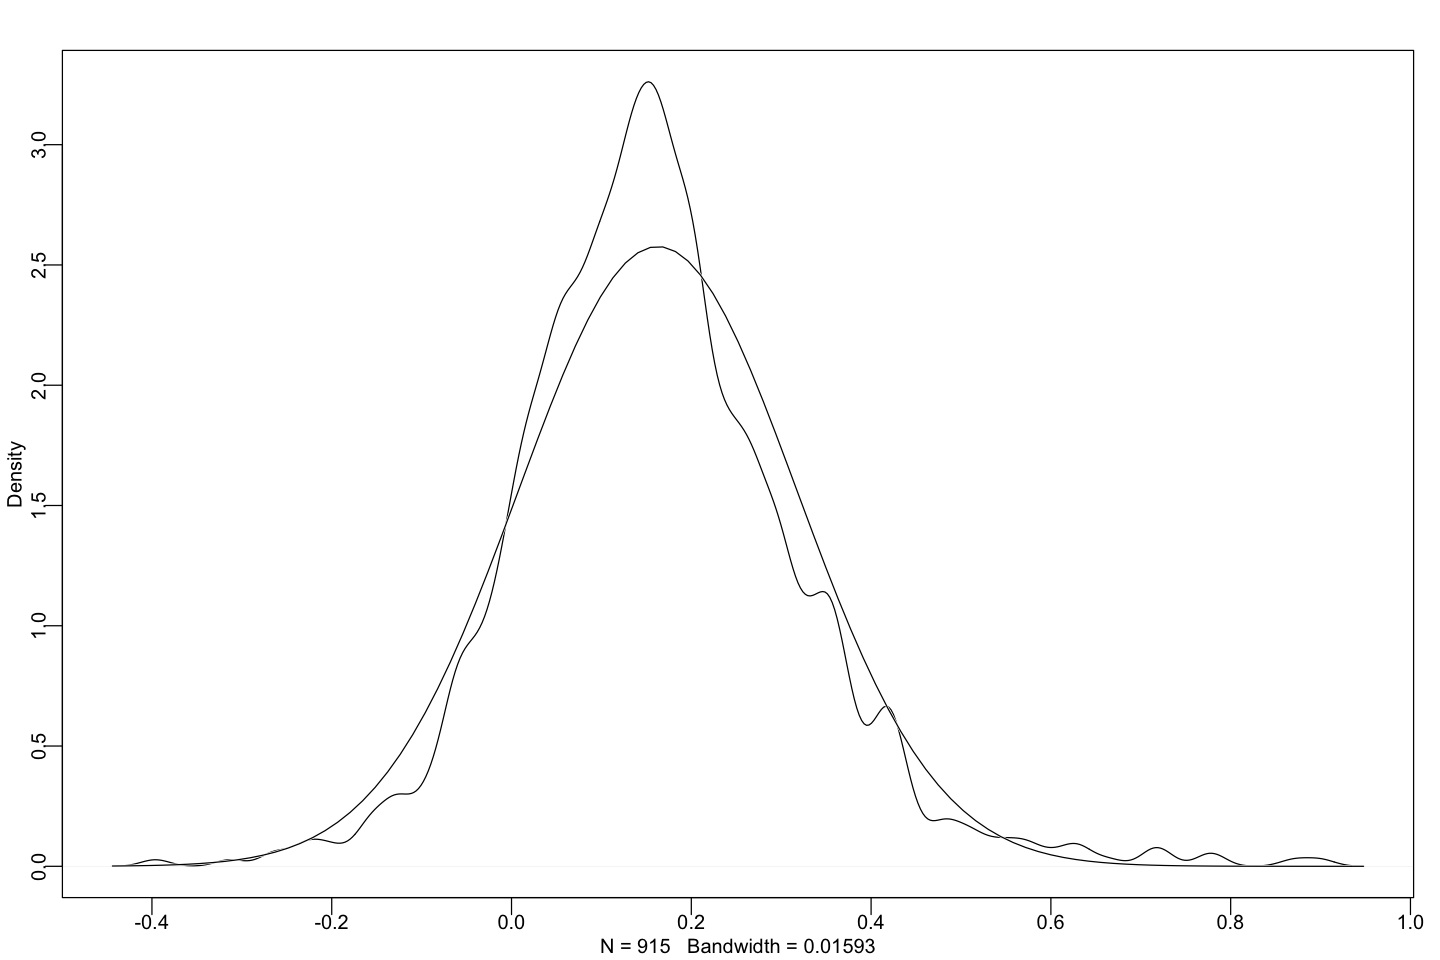

In [487]:
class(df$SentimentLTR)
summary(df$SentimentLTR)
dens(df$SentimentLTR,norm.comp=TRUE)

I am not standardizing or centering SentimentLTR because a zero value is an important marker for determining valence.

### Temporal

#### Year of Writing

[1] "integer"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1804    1856    1863    1865    1880    1913 

[1] 21.24681

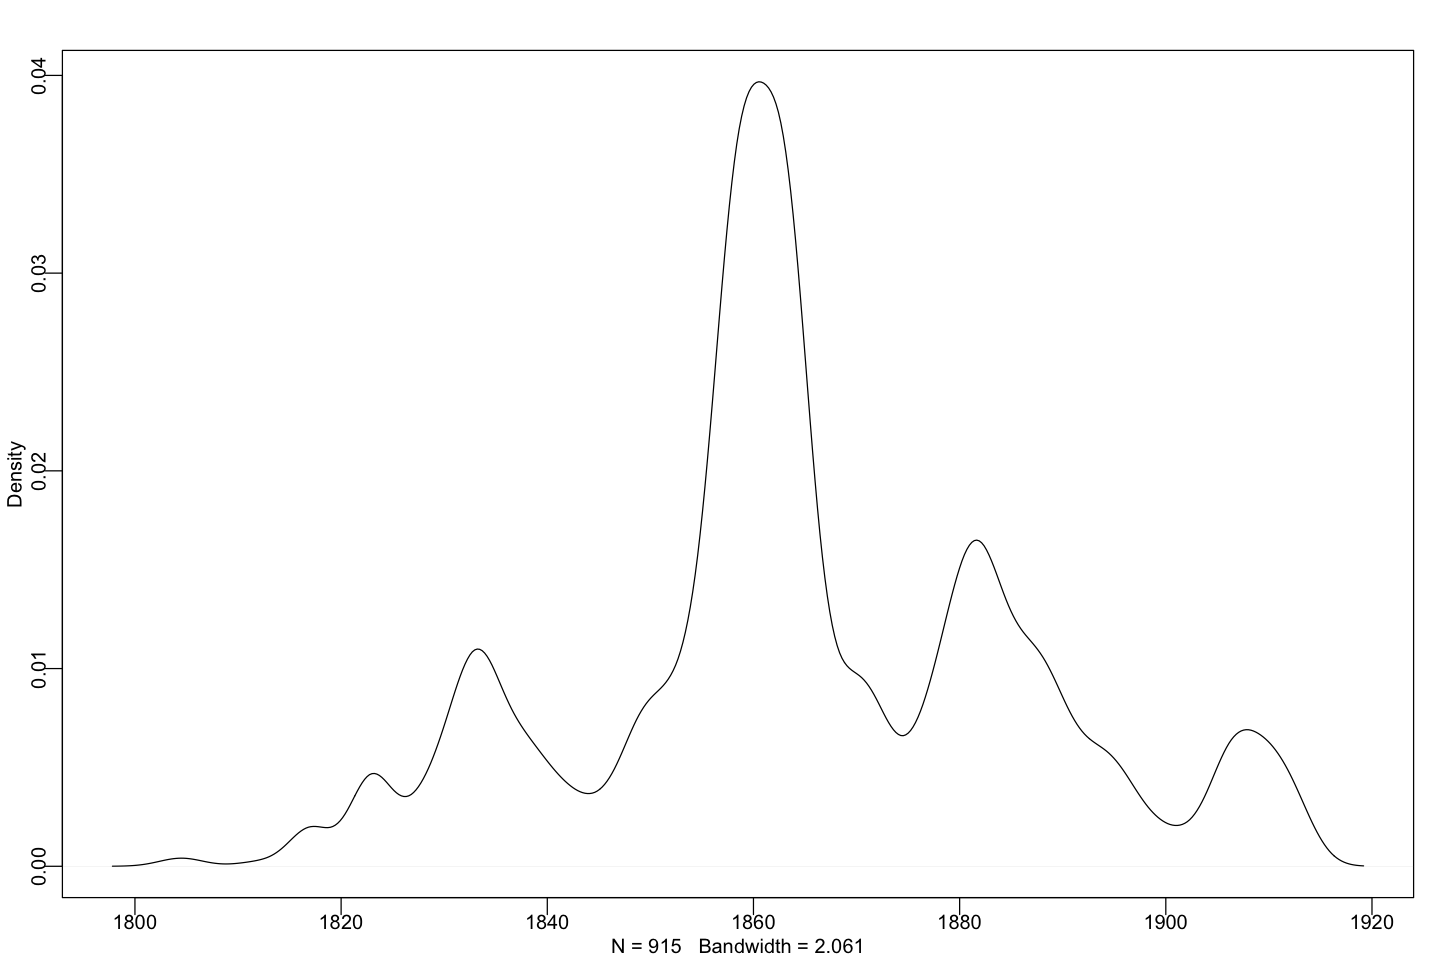

In [812]:
#Check class, summary and distribution of docyear
class(df$docyear)
summary(df$docyear)
dens(df$docyear)
sd(df$docyear)

[1] "numeric"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.86341 -0.41598 -0.08652  0.00000  0.71360  2.26678 

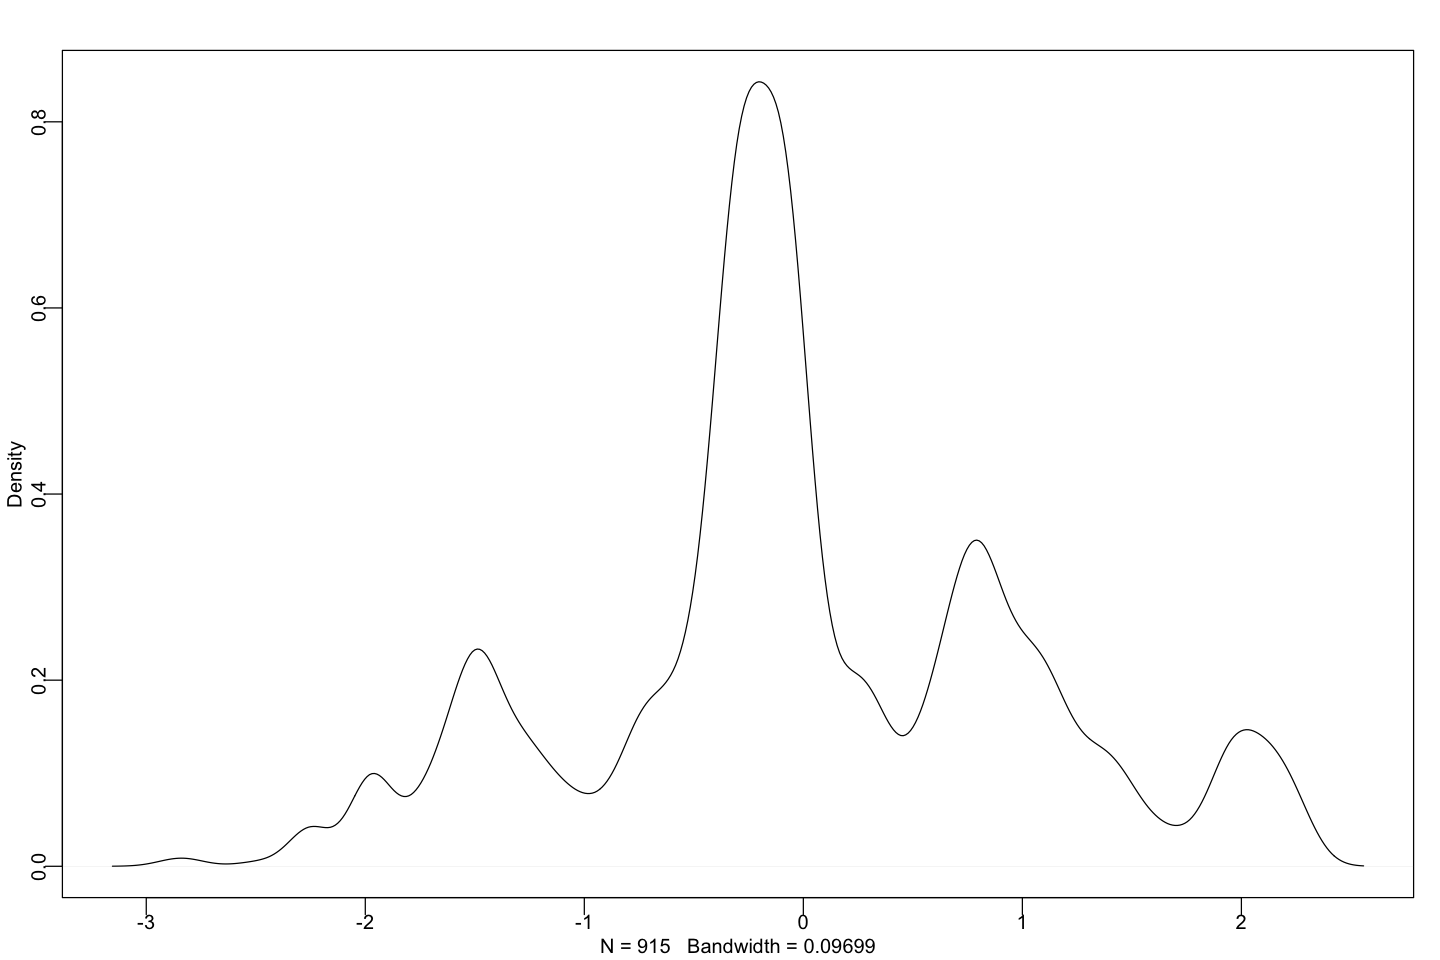

In [489]:
df$docyear.s <- (df$docyear - mean(df$docyear))/sd(df$docyear)
class(df$docyear.s)
summary(df$docyear.s)
dens(df$docyear.s)

In [490]:
# Define model
m1_docyear <- alist(
    SentimentLTR ~ dnorm(mu,sigma),
    mu <- a + b*df$docyear.s,
    a ~ dnorm(0,0.5),
    b ~ dnorm(0,30),
    sigma ~ dunif(0,50)
)

In [491]:
f1_docyear <- map(m1_docyear,data=df)

In [492]:
precis(f1_docyear, prob=.9)

       Mean StdDev  5.0% 95.0%
a      0.16   0.01  0.15  0.17
b     -0.03   0.01 -0.04 -0.02
sigma  0.15   0.00  0.15  0.16

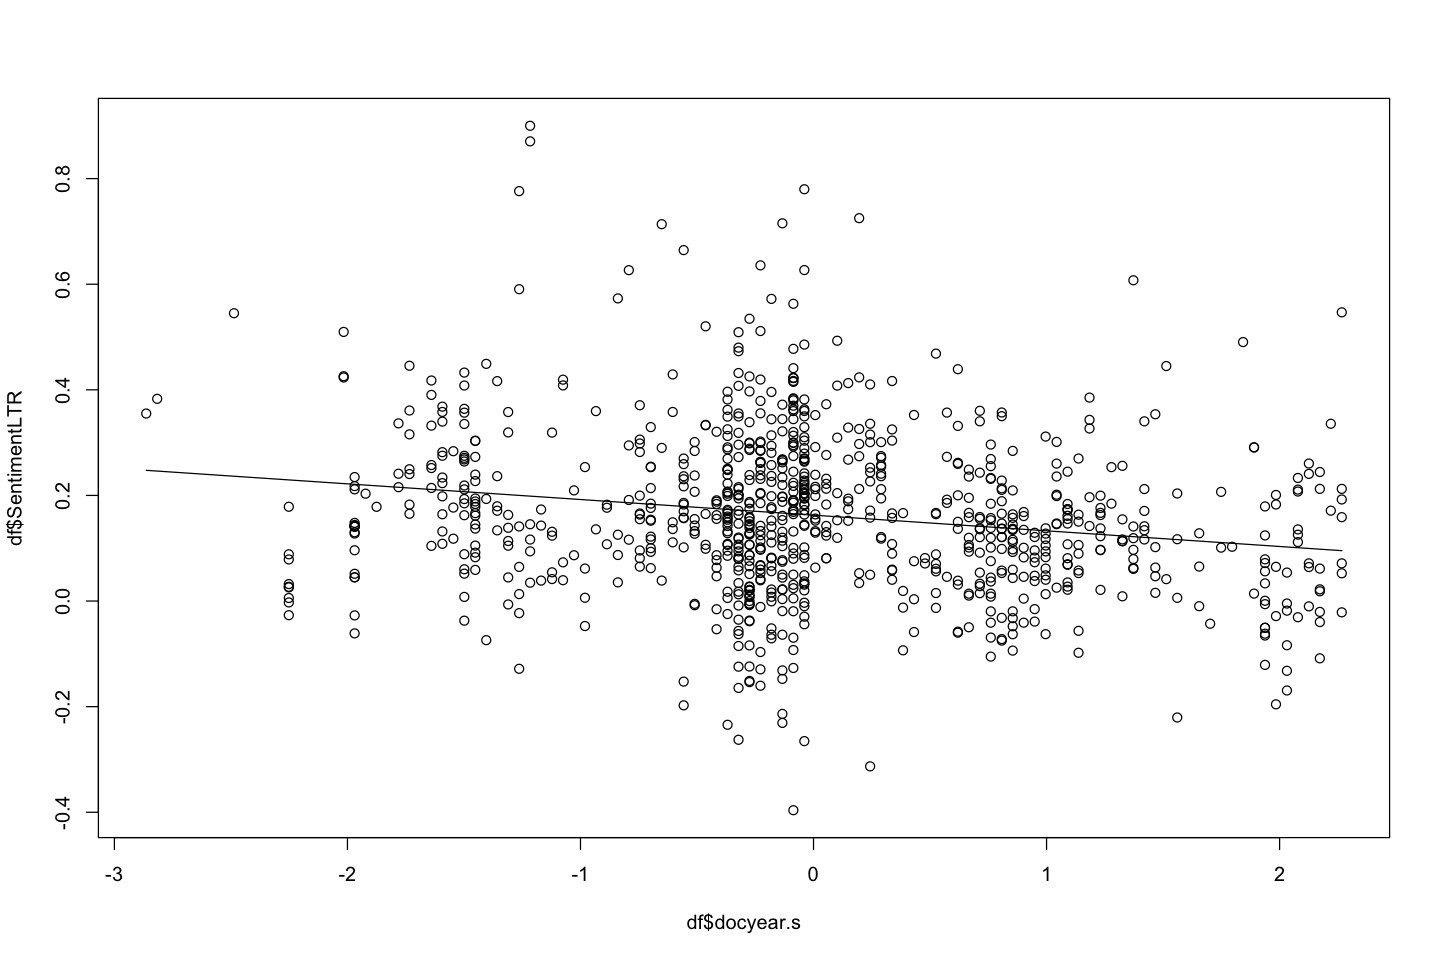

In [493]:
# set up plot window for projector visibility
options(repr.plot.width=12, repr.plot.height=8)

# first plot the data points
plot(df$docyear.s,df$SentimentLTR)
# note: here we used the plot(x,y) form of the plot function,
# which plots x on the horizontal axis against y on the vertical.
# There is another way to make the same scatter plot using the
# 'formula' form of plot:
#    plot(log_income~age.s,data=d)
# This takes the form of plot(y~x, data=d). The two forms create
# identical output.

# get the coefficients
cf1 <- coef(f1_docyear)
a_fit <- cf1['a']
b_fit <- cf1['b']

# create a grid of hypothetical ages to predict
n_grid <- 400
grid <- seq(min(df$docyear.s),max(df$docyear.s),length.out=n_grid)

# plot the "deterministic" portion of the model:
#    mu <- a + b1*age.s

lines(grid , a_fit + b_fit*grid)

TO DO: Make a better plot using code at http://localhost:8889/notebooks/SOCI620/20190204_AM_HW3.ipynb

#### Years since migration

[1] "integer"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    2.00    6.00   12.88   18.00   62.00 

[1] 15.81425

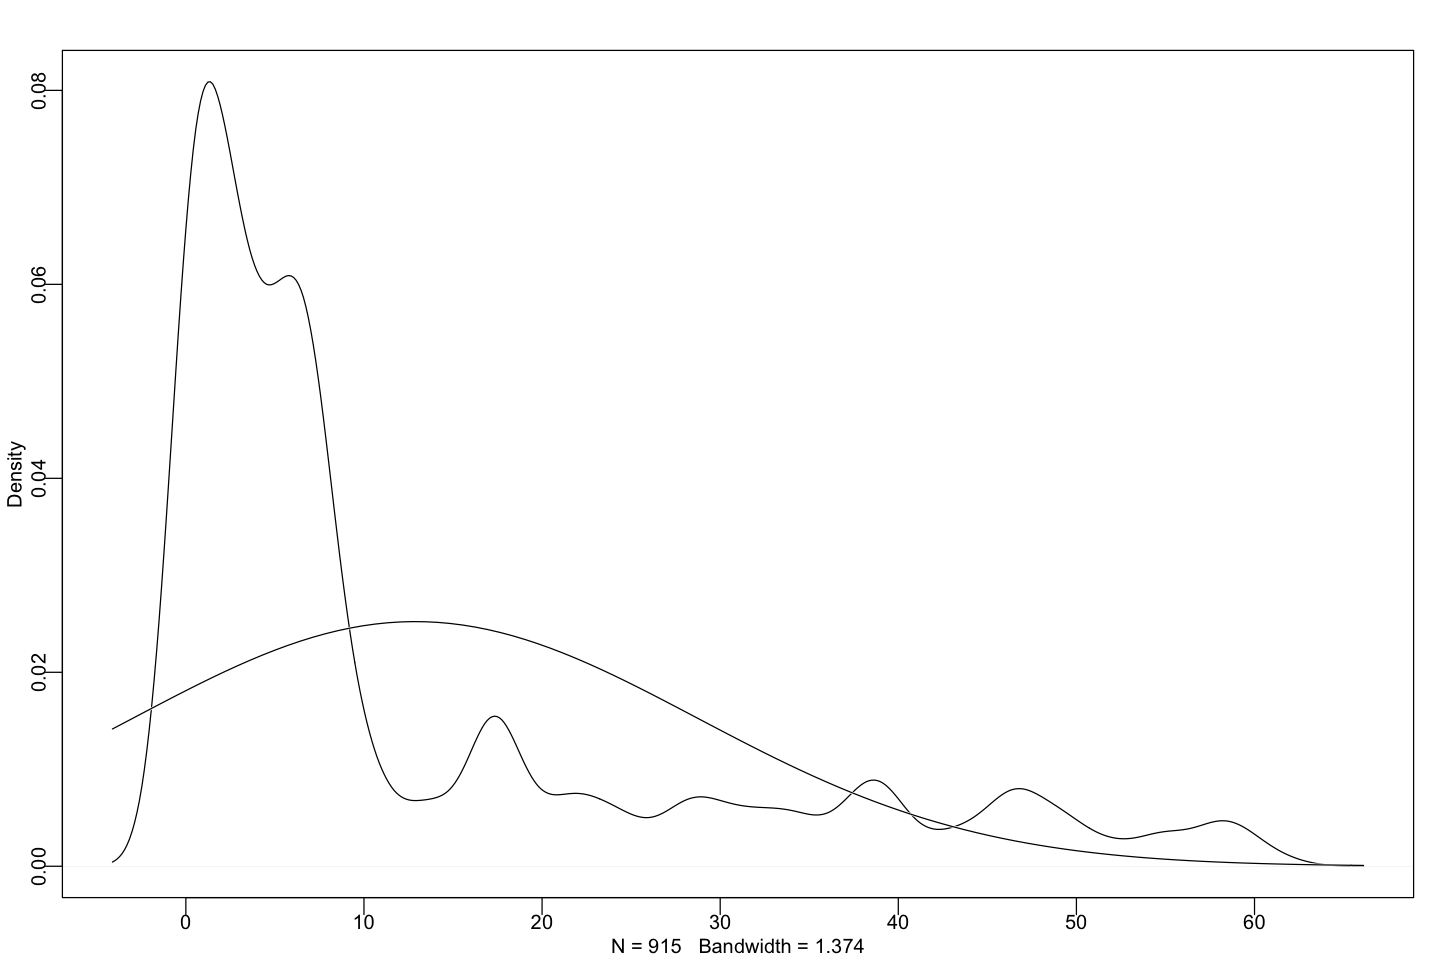

In [1015]:
#Check class, summary and distribution of docyear
class(df$sinceMigration)
summary(df$sinceMigration)
dens(df$sinceMigration, norm.comp = TRUE)
sd(df$sinceMigration)

[1] "numeric"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.8144 -0.6880 -0.4350  0.0000  0.3238  3.1061 

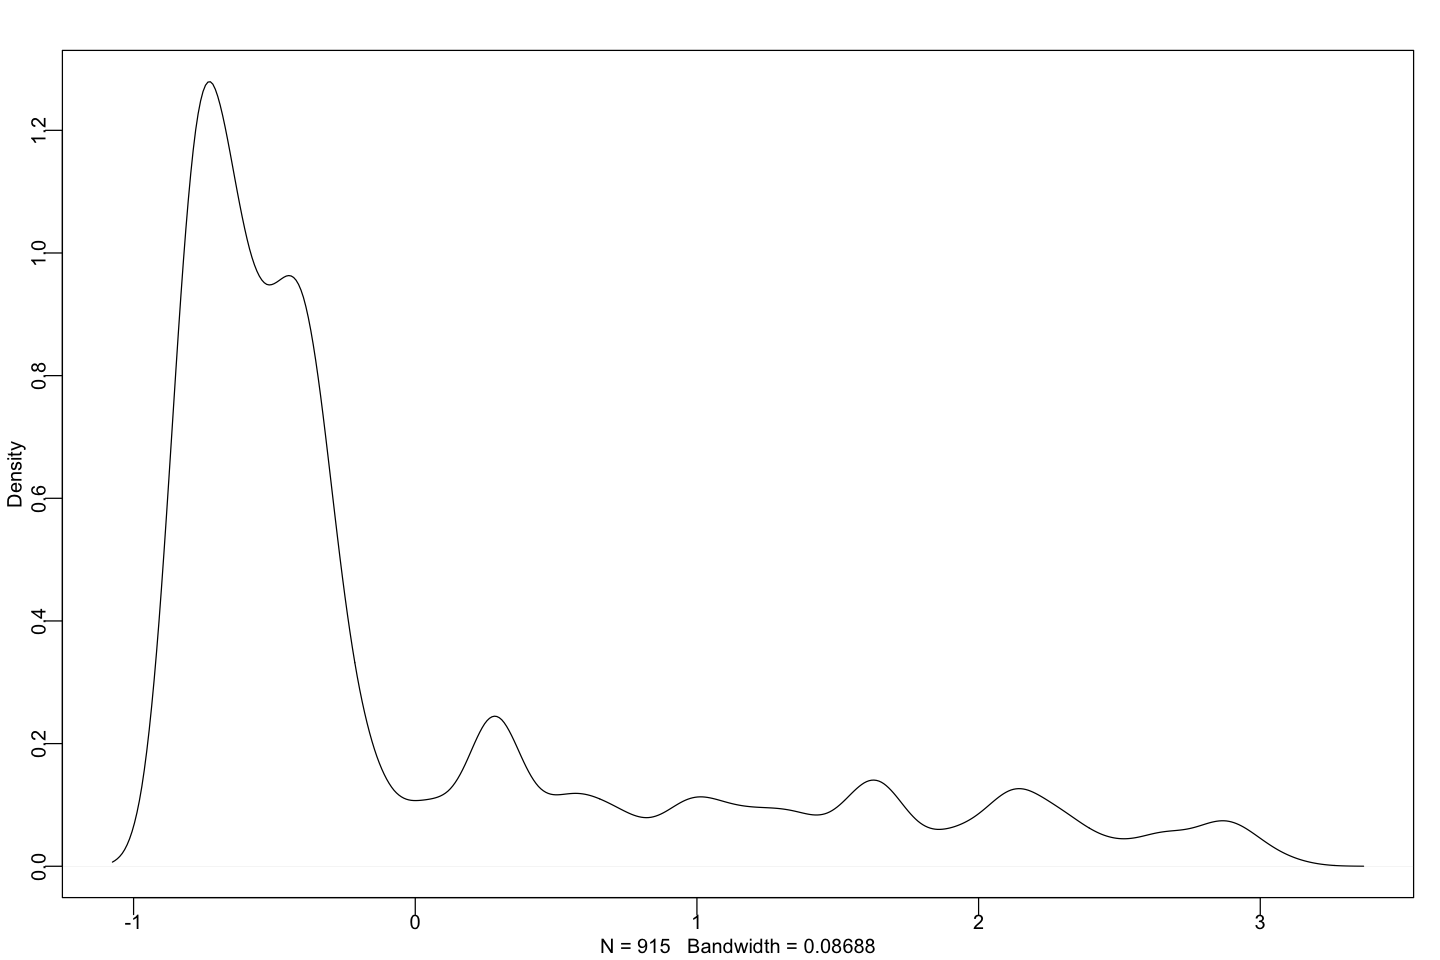

In [1001]:
df$sinceMigration.s <- (df$sinceMigration - mean(df$sinceMigration))/sd(df$sinceMigration)
class(df$sinceMigration.s)
summary(df$sinceMigration.s)
dens(df$sinceMigration.s)

In [1002]:
# Define model
m1_sinceMigration <- alist(
    SentimentLTR ~ dnorm(mu,sigma),
    mu <- a + b*sinceMigration.s,
    a ~ dnorm(0,0.5),
    b ~ dnorm(0,30),
    sigma ~ dunif(0,50)
)

In [1003]:
f1_sinceMigration <- map(m1_sinceMigration,data=df)

In [1004]:
precis(f1_sinceMigration, prob=.9)

      Mean StdDev 5.0% 95.0%
a     0.16   0.01 0.15  0.17
b     0.02   0.01 0.01  0.03
sigma 0.15   0.00 0.15  0.16

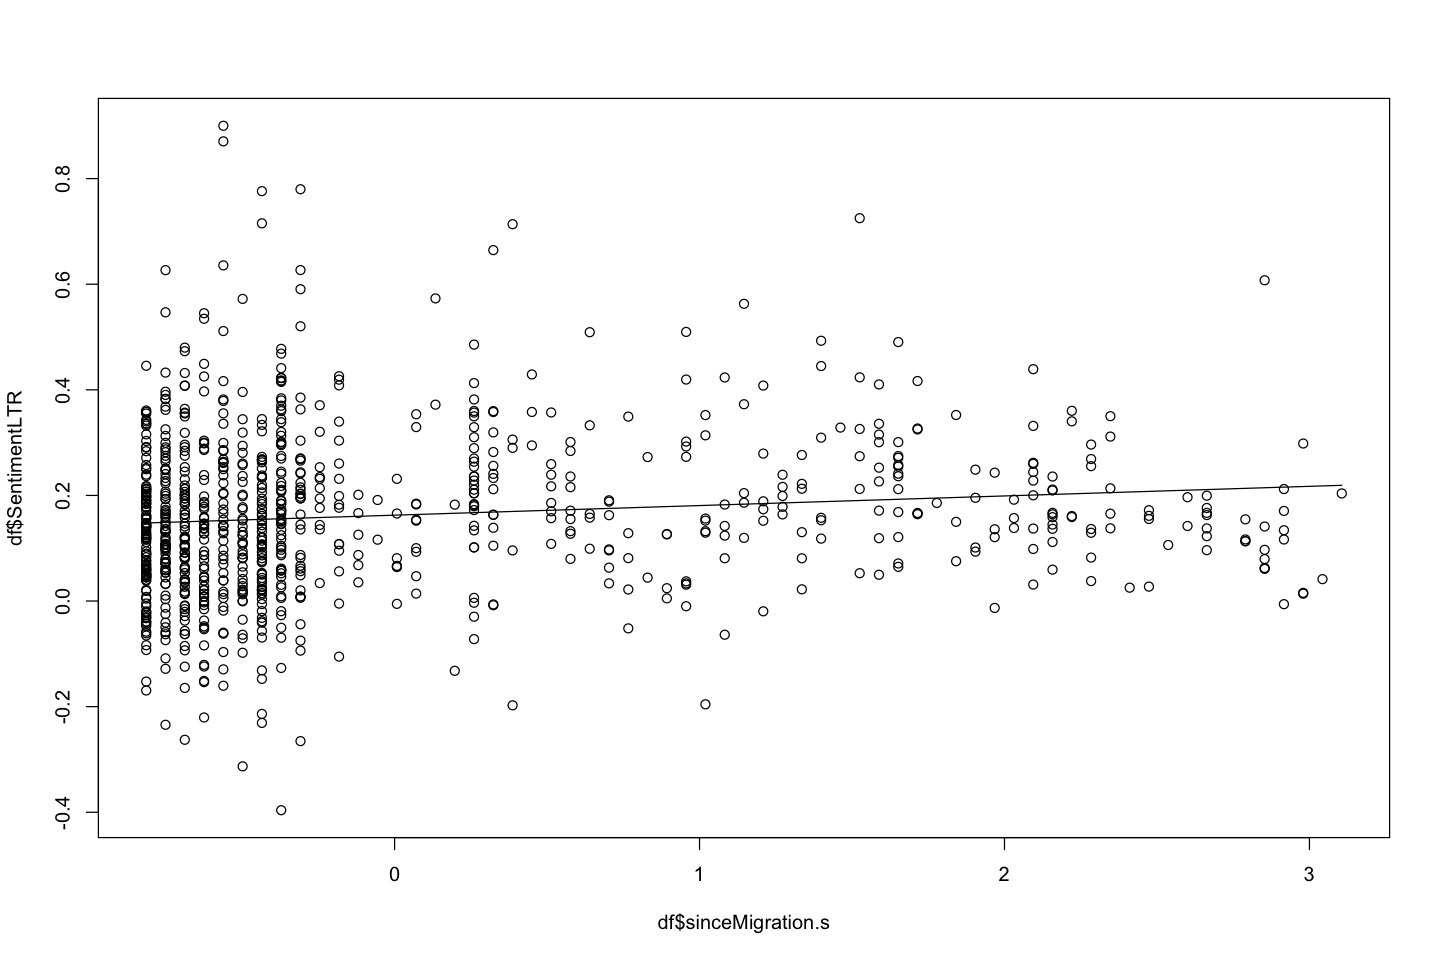

In [1005]:
# set up plot window for projector visibility
options(repr.plot.width=12, repr.plot.height=8)

# first plot the data points
plot(df$sinceMigration.s,df$SentimentLTR)
# note: here we used the plot(x,y) form of the plot function,
# which plots x on the horizontal axis against y on the vertical.
# There is another way to make the same scatter plot using the
# 'formula' form of plot:
#    plot(log_income~age.s,data=d)
# This takes the form of plot(y~x, data=d). The two forms create
# identical output.

# get the coefficients
cf1 <- coef(f1_sinceMigration)
a_fit <- cf1['a']
b_fit <- cf1['b']

# create a grid of hypothetical ages to predict
n_grid <- 400
grid <- seq(min(df$sinceMigration.s),max(df$sinceMigration.s),length.out=n_grid)

# plot the "deterministic" portion of the model:
#    mu <- a + b1*age.s

lines(grid , a_fit + b_fit*grid)

In [1006]:
cf <- coef(f1_sinceMigration)

In [1007]:
cf

a          b      sigma 
0.16262109 0.01820099 0.15367313

In [1023]:
cf['a'] + cf['b']*2

a 
0.1990231

#### Location of text within letter

#### Location

In [546]:
#Check class, summary and distribution of docyear
class(df$authorLocation)
summary(df$authorLocation)

[1] "factor"

Canada         Other United States 
          427             7           481

In [802]:
# Make indicator variables
df$al_canada <- as.numeric(df$authorLocation=='Canada')
df$al_usa <- as.numeric(df$authorLocation=='United States')
df$al_other <- as.numeric(df$authorLocation=='Other')

In [803]:
sum(df$al_canada)
sum(df$al_usa)
sum(df$al_other)

[1] 427

[1] 481

[1] 7

In [804]:
unique(df[c('authorLocation','al_usa','al_other')])

,authorLocation,al_usa,al_other
1,United States,1,0
173,Other,0,1
229,Canada,0,0


In [805]:
# Define model
m1_authorLocation <- alist(
    SentimentLTR ~ dnorm(mu,sigma),
    mu <- a + b_usa*al_usa + b_other*al_other,
    a ~ dnorm(0,0.5),
    b_usa ~ dnorm(0,30),
    b_other ~ dnorm(0,30),
    sigma ~ dunif(0,50)
)

In [806]:
f1_authorLocation <- map(m1_authorLocation,data=df)

In [807]:
precis(f1_authorLocation, prob=.9)

         Mean StdDev  5.0% 95.0%
a        0.20   0.01  0.19  0.22
b_usa   -0.08   0.01 -0.09 -0.06
b_other -0.02   0.06 -0.11  0.07
sigma    0.15   0.00  0.14  0.16

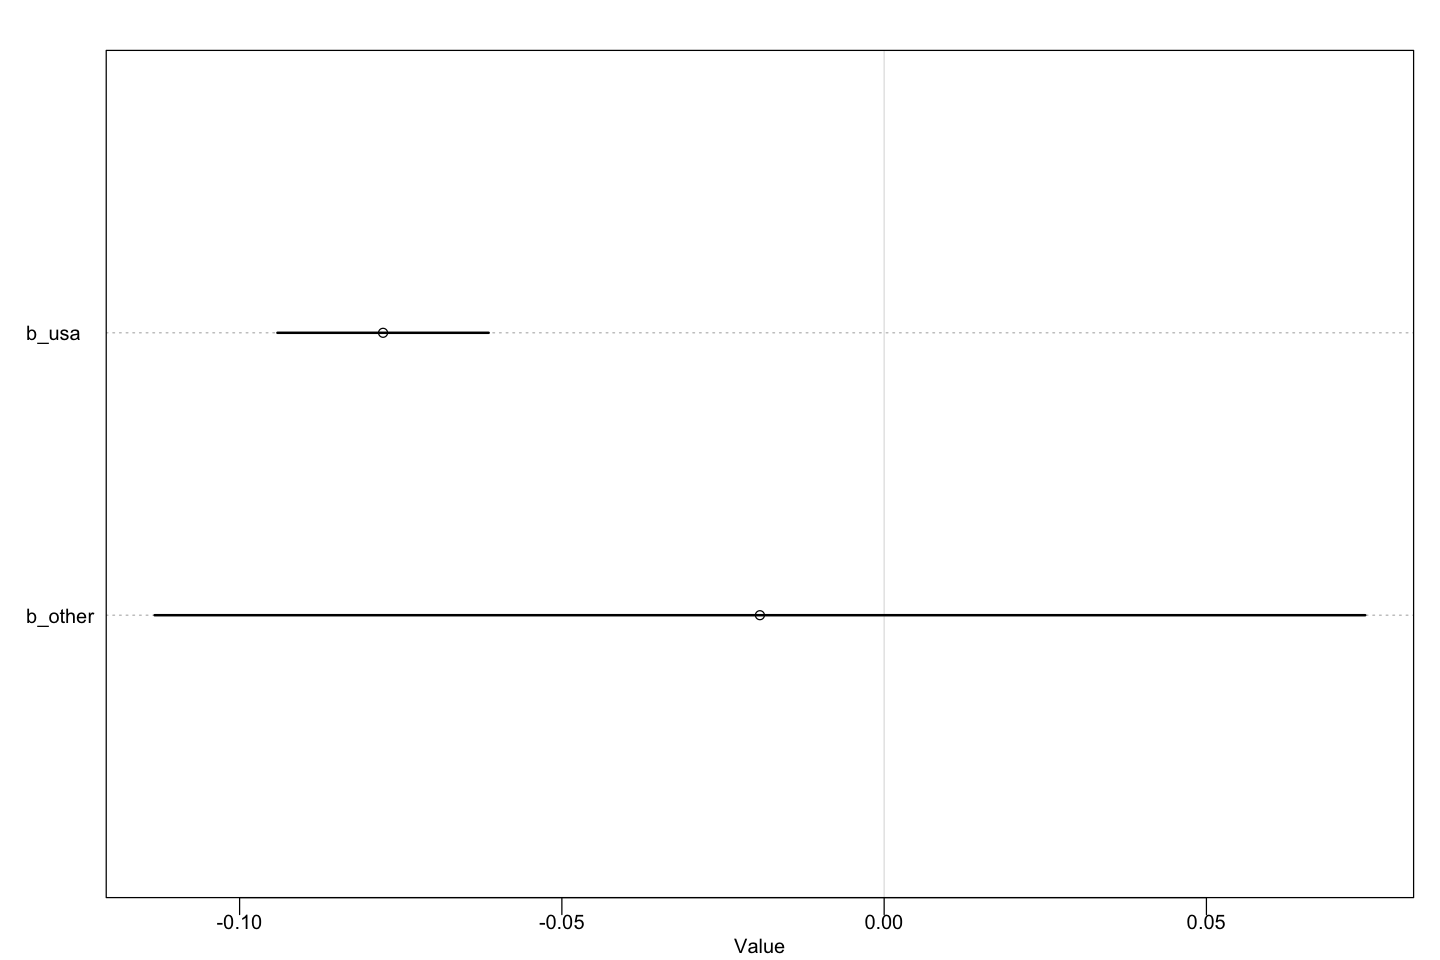

In [808]:
plot(
    precis(
        f1_authorLocation,prob=.90,
        pars = c('b_usa','b_other')
    )
)

#### Gender

In [529]:
#Check class, summary and distribution of docyear
class(df$authorgender)
summary(df$authorgender)

[1] "factor"

F   M 
532 383

In [536]:
df$authorgender.d  <-  NA
df$authorgender.d[df$authorgender=="F"]  <- "1"
df$authorgender.d[df$authorgender=="M"]  <- "0"
df$authorgender.d  <- as.integer(df$authorgender.d)
class(df$authorgender.d)
table(df$authorgender.d)

[1] "integer"


  0   1 
383 532 

In [537]:
# Define model
m1_authorgender <- alist(
    SentimentLTR ~ dnorm(mu,sigma),
    mu <- a + b*authorgender.d,
    a ~ dnorm(0,0.5),
    b ~ dnorm(0,30),
    sigma ~ dunif(0,50)
)

In [538]:
f1_authorgender <- map(m1_authorgender,data=df)

In [539]:
precis(f1_authorgender, prob=.9)

      Mean StdDev  5.0% 95.0%
a     0.16   0.01  0.15  0.17
b     0.00   0.01 -0.02  0.02
sigma 0.15   0.00  0.15  0.16

In [541]:
# Take a sample
samp1e <- extract.samples(f1_authorgender,3000)

In [542]:
# Get density of posterior estimates for men and women
posterior_mu_men <- density(sample$a)
posterior_mu_women <- density(sample$a + samp1e$b)

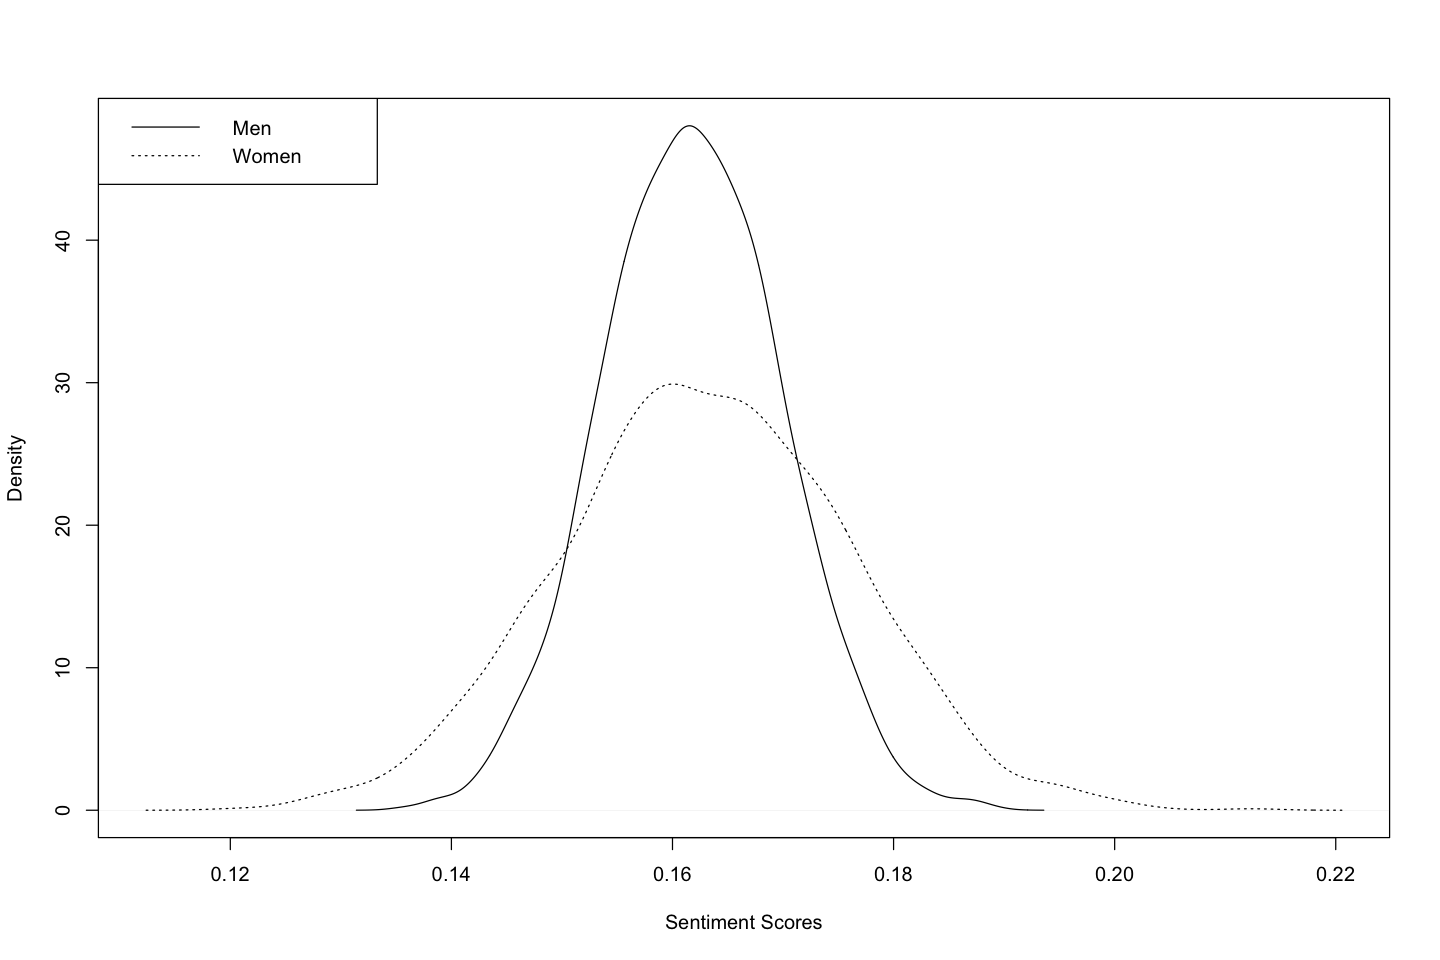

In [545]:
# What are the limits for the plot
xlim <- range(posterior_mu_men$x, posterior_mu_women$x)
ylim <- range(posterior_mu_men$y, posterior_mu_women$y)


# Plot it
plot(posterior_mu_men,xlab='Sentiment Scores',xlim=xlim,ylim=ylim, main = "")
lines(posterior_mu_women,lty=3)

# add a legend
legend('topleft',lty=c(1,3),legend=c("Men","Women"))

#### Age

[1] "integer"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.00   26.00   39.00   39.99   46.00   85.00 

[1] 17.30271

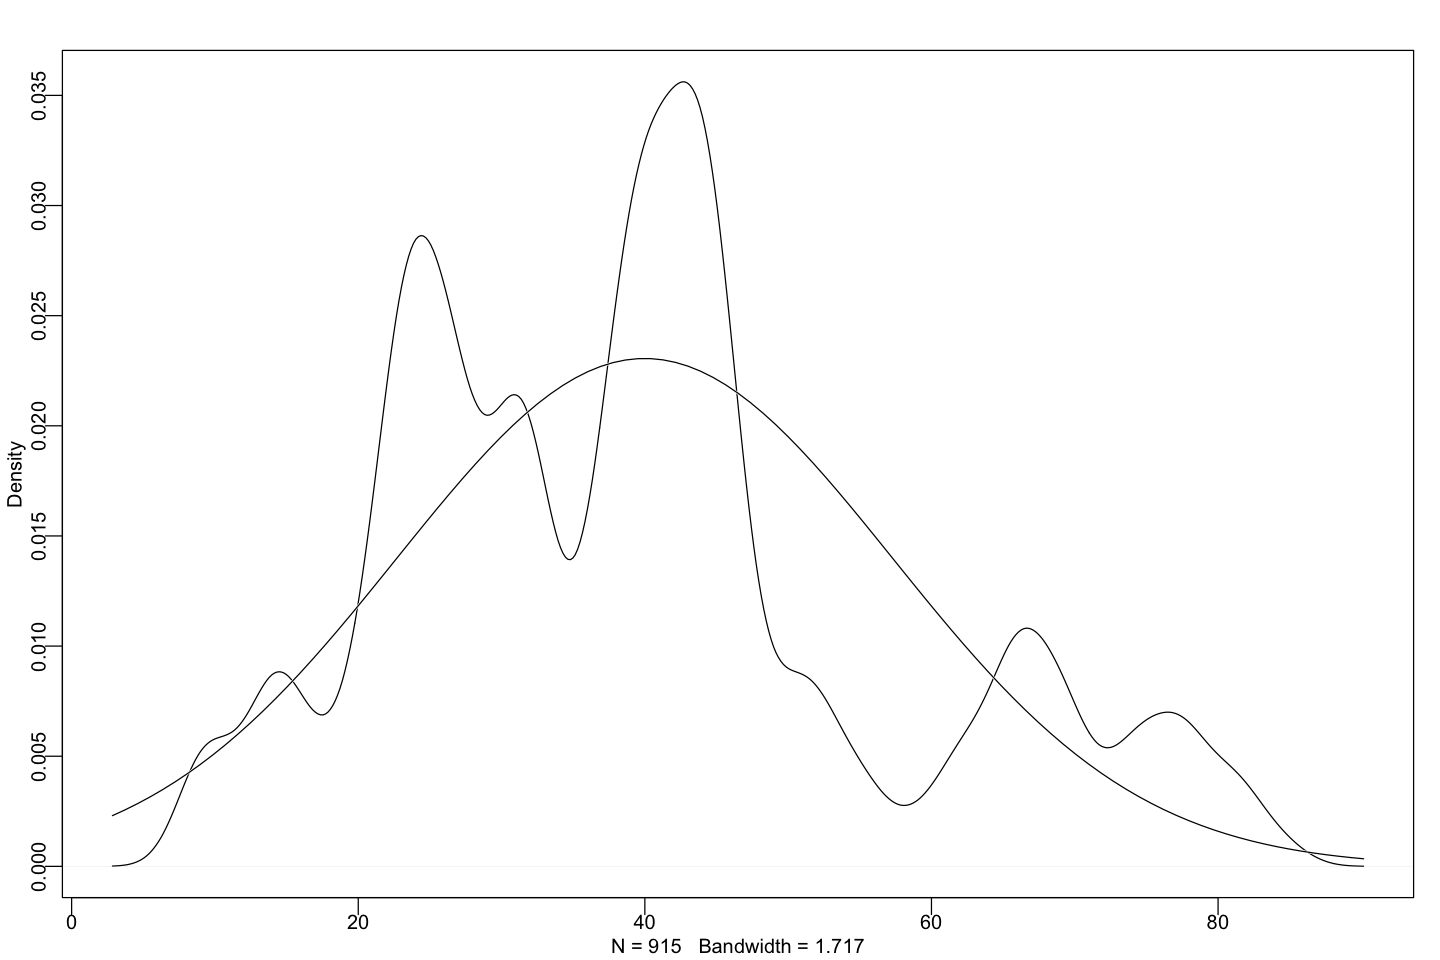

In [1031]:
#Check class, summary and distribution of docyear
class(df$agewriting)
summary(df$agewriting)
dens(df$agewriting, norm.comp = TRUE)
sd(df$agewriting)

[1] "numeric"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.84885 -0.80855 -0.05723  0.00000  0.34733  2.60132 

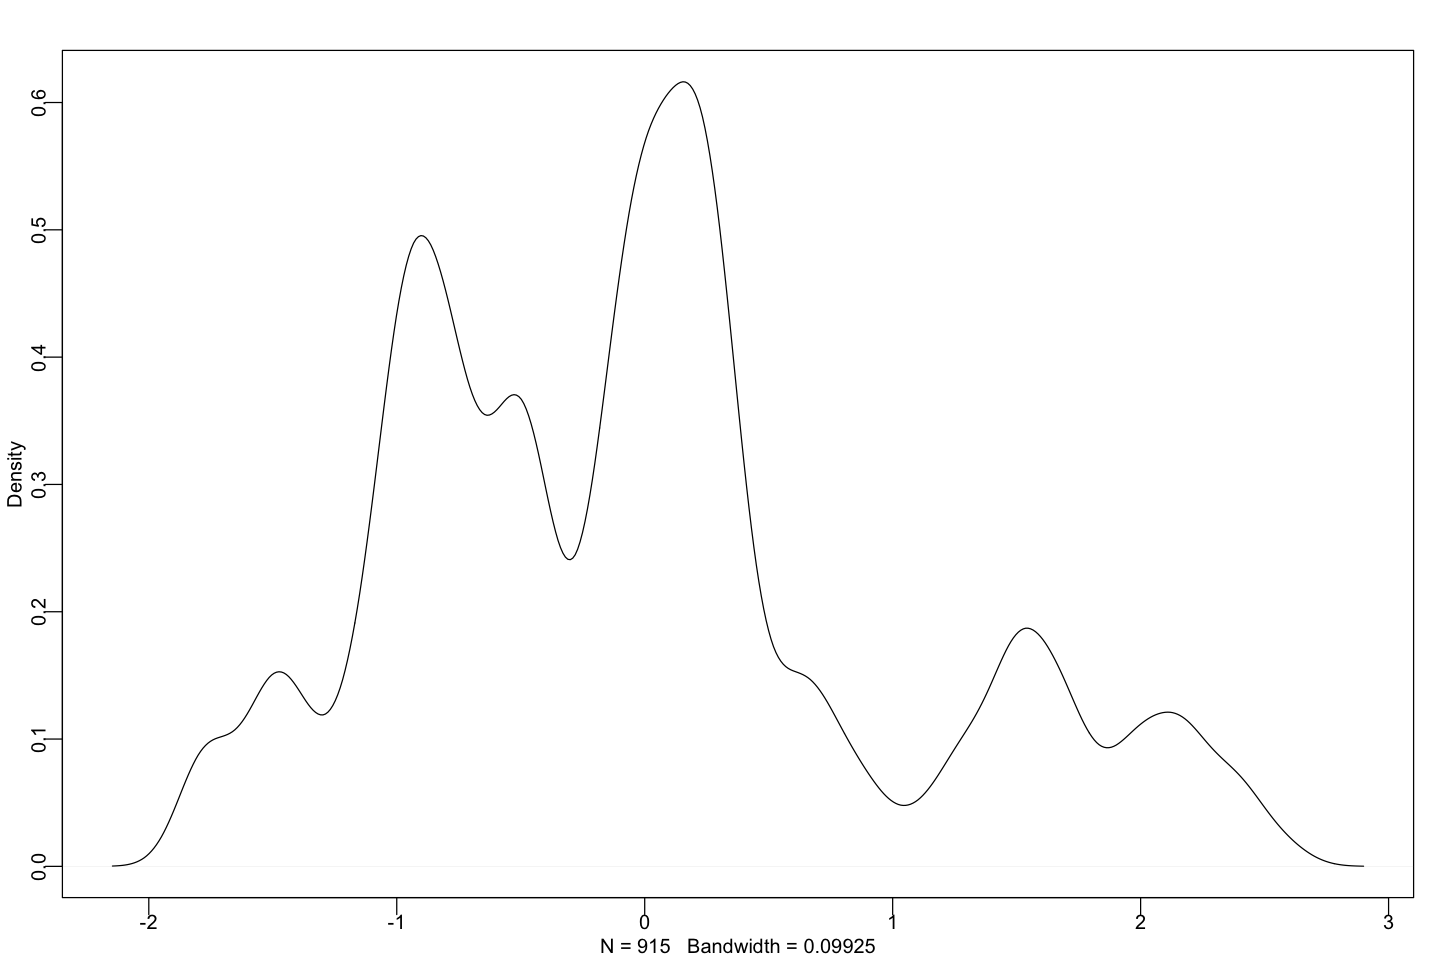

In [505]:
df$agewriting.s <- (df$agewriting - mean(df$agewriting))/sd(df$agewriting)
class(df$agewriting.s)
summary(df$agewriting.s)
dens(df$agewriting.s)

In [1026]:
# Define model
m1_agewriting.s <- alist(
    SentimentLTR ~ dnorm(mu,sigma),
    mu <- a + b*agewriting.s,
    a ~ dnorm(0,0.5),
    b ~ dnorm(0,30),
    sigma ~ dunif(0,50)
)

In [1027]:
f1_agewriting.s <- map(m1_agewriting.s,data=df)

In [1028]:
precis(f1_agewriting.s, prob=.9)

      Mean StdDev 5.0% 95.0%
a     0.16   0.01 0.15  0.17
b     0.02   0.01 0.02  0.03
sigma 0.15   0.00 0.15  0.16

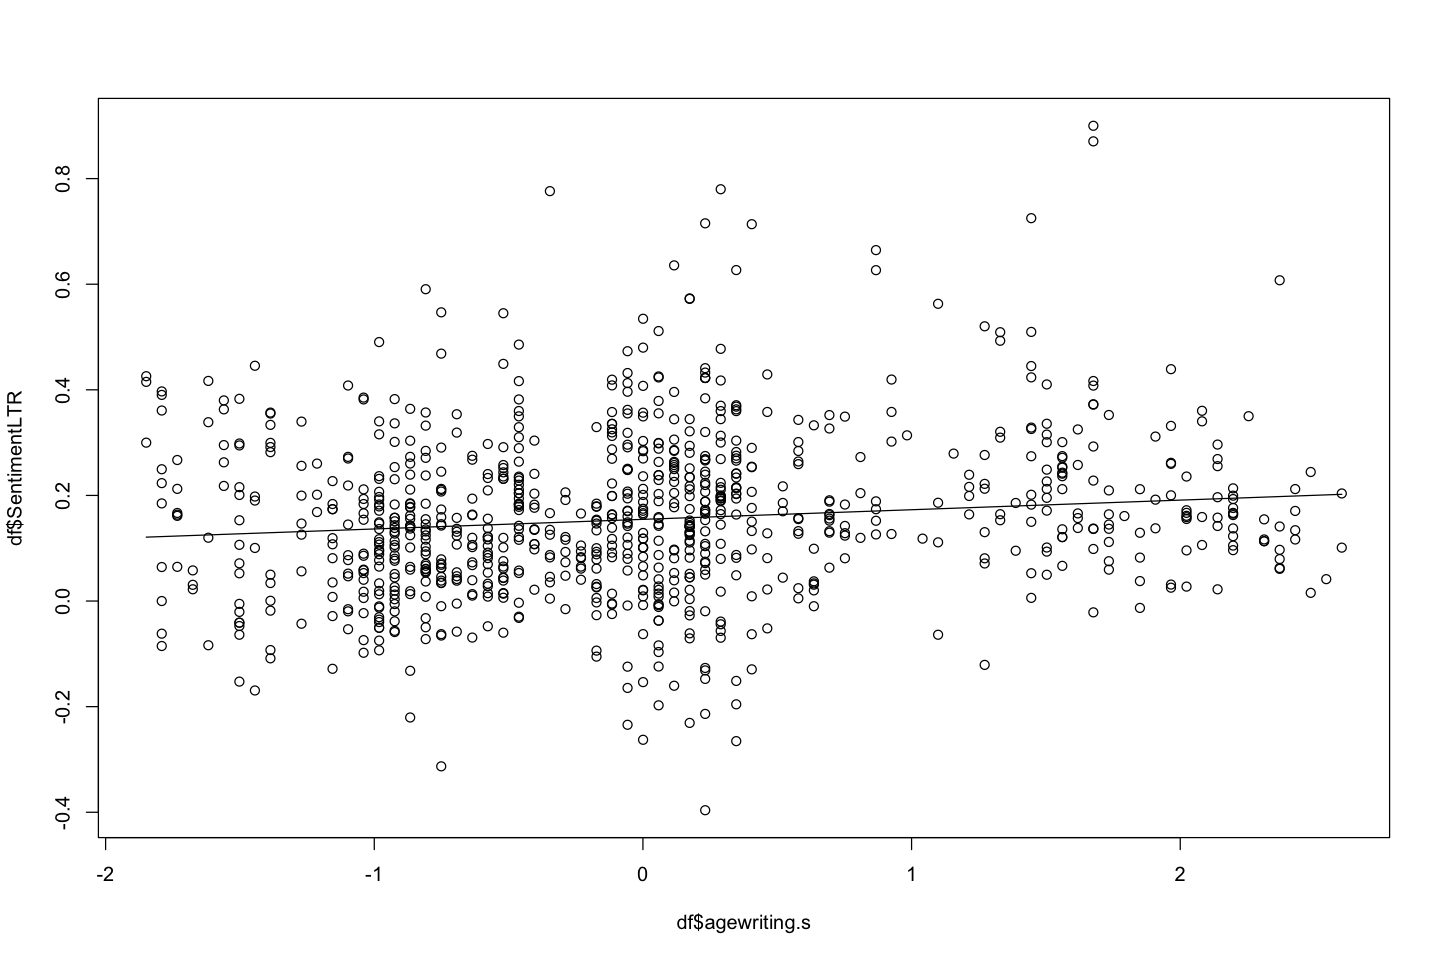

In [512]:
# set up plot window for projector visibility
options(repr.plot.width=12, repr.plot.height=8)

# first plot the data points
plot(df$agewriting.s,df$SentimentLTR)
# note: here we used the plot(x,y) form of the plot function,
# which plots x on the horizontal axis against y on the vertical.
# There is another way to make the same scatter plot using the
# 'formula' form of plot:
#    plot(log_income~age.s,data=d)
# This takes the form of plot(y~x, data=d). The two forms create
# identical output.

# get the coefficients
cf1 <- coef(f1_sinceMigration)
a_fit <- cf1['a']
b_fit <- cf1['b']

# create a grid of hypothetical ages to predict
n_grid <- 400
grid <- seq(min(df$agewriting.s),max(df$agewriting.s),length.out=n_grid)

# plot the "deterministic" portion of the model:
#    mu <- a + b1*age.s

lines(grid , a_fit + b_fit*grid)

In [1039]:
cf1['a'] + cf1['b']*-1

a 
0.1444201

#### Culture

In [592]:
#Check class, summary and distribution of docyear
class(df$nationalOrigin)
summary(df$nationalOrigin)

[1] "factor"

Czech   Dushane; Xhosa            Dutch          English 
               4                3               41              365 
        European          Finnish French; Prussian           German 
               1               12                7              145 
           Irish  Irish; Scottish          Italian       Lithuanian 
              27               17               59                2 
       Norwegian           Polish         Prussian          Russian 
             107                3               34               17 
        Scottish          Spanish 
              69                2

In [595]:
# Make indicator variables
df$no_czech <- as.numeric(df$nationalOrigin=='Czech')
df$no_xhosa <- as.numeric(df$nationalOrigin=='Dushane; Xhosa')
df$no_dutch <- as.numeric(df$nationalOrigin=='Dutch')
df$no_european <- as.numeric(df$nationalOrigin=='European')
df$no_finnish <- as.numeric(df$nationalOrigin=='Finnish')
df$no_frenchPrussian <- as.numeric(df$nationalOrigin=='French; Prussian' | df$nationalOrigin=='Prussian')
df$no_german <- as.numeric(df$nationalOrigin=='German')
df$no_irish <- as.numeric(df$nationalOrigin=='Irish')
df$no_irishScottish <- as.numeric(df$nationalOrigin=='Irish; Scottish')
df$no_italian <- as.numeric(df$nationalOrigin=='Italian')
df$no_lithuanian <- as.numeric(df$nationalOrigin=='Lithuanian')
df$no_norwegian <- as.numeric(df$nationalOrigin=='Norwegian')
df$no_polish <- as.numeric(df$nationalOrigin=='Polish')
df$no_russian <- as.numeric(df$nationalOrigin=='Russian')
df$no_scottish <- as.numeric(df$nationalOrigin=='Scottish')
df$no_spanish <- as.numeric(df$nationalOrigin=='Spanish')
unique(df[c('nationalOrigin',
            'no_czech',
            'no_xhosa',
            'no_dutch',
            'no_european',
            'no_finnish',
            'no_frenchPrussian',
            'no_german',
            'no_irish',
            'no_irishScottish',
            'no_italian',
            'no_lithuanian',
            'no_norwegian',
            'no_polish',
            'no_russian',
            'no_scottish',
            'no_spanish'
           )])

,nationalOrigin,no_czech,no_xhosa,no_dutch,no_european,no_finnish,no_frenchPrussian,no_german,no_irish,no_irishScottish,no_italian,no_lithuanian,no_norwegian,no_polish,no_russian,no_scottish,no_spanish
1,German,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
137,Italian,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
193,Russian,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
194,Lithuanian,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
195,English,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
196,Norwegian,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
200,Spanish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201,Dutch,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
205,Polish,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
206,Irish,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [599]:
vars <- c('no_czech',
            'no_xhosa',
            'no_dutch',
            'no_european',
            'no_finnish',
            'no_frenchPrussian',
            'no_german',
            'no_irish',
            'no_irishScottish',
            'no_italian',
            'no_lithuanian',
            'no_norwegian',
            'no_polish',
            'no_russian',
            'no_scottish',
            'no_spanish')

In [641]:
str(df[vars])

'data.frame':	915 obs. of  17 variables:
 $ nationalOrigin   : Factor w/ 18 levels "Czech","Dushane; Xhosa",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ no_czech         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_xhosa         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_dutch         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_european      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_finnish       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_frenchPrussian: num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_german        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ no_irish         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_irishScottish : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_italian       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_lithuanian    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_norwegian     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_polish        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_russian       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_scottish      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ no_spanish       : num  0 0 0 0 0 0 0 0 0 0 ...


In [647]:
# Define model
m1_countryOrigin <- alist(
    SentimentLTR ~ dnorm(mu,sigma),
    mu <- a + b_czech*no_czech + 
    b_xhosa*no_xhosa + 
    b_dutch*no_dutch +
    b_european*no_european +
    b_finnish*no_finnish +
    b_frenchPrussian*no_frenchPrussian +
    b_german*no_german +
    b_irish*no_irish +
    b_irishScottish*no_irishScottish +
    b_italian*no_italian +
    b_lithuanian*no_lithuanian +
    b_norwegian*no_norwegian +
    b_polish*no_polish +
    b_russian*no_russian +
    b_scottish*no_scottish +
    b_spanish*no_spanish,
    
    a ~ dnorm(0,0.5),
    
    b_czech ~ dnorm(0,30),
    b_xhosa ~ dnorm(0,30),
    b_dutch ~ dnorm(0,30),
    b_european ~ dnorm(0,30),
    b_finnish ~ dnorm(0,30),
    b_frenchPrussian ~ dnorm(0,30),
    b_german ~ dnorm(0,30),
    b_irish ~ dnorm(0,30),
    b_irishScottish ~ dnorm(0,30),
    b_italian ~ dnorm(0,30),
    b_lithuanian ~ dnorm(0,30),
    b_norwegian ~ dnorm(0,30),
    b_polish ~ dnorm(0,30),
    b_russian ~ dnorm(0,30),
    b_scottish ~ dnorm(0,30),
    b_spanish ~ dnorm(0,30),
    
    sigma ~ dunif(0,50)
)


In [648]:
f1_countryOrigin <- map(m1_countryOrigin,data=df)

In [1049]:
precis(f1_countryOrigin, prob=.9)

                  Mean StdDev  5.0% 95.0%
a                 0.21   0.01  0.20  0.22
b_czech           0.07   0.07 -0.05  0.19
b_xhosa          -0.21   0.08 -0.35 -0.08
b_dutch          -0.10   0.02 -0.13 -0.06
b_european        0.15   0.14 -0.09  0.38
b_finnish        -0.02   0.04 -0.09  0.05
b_frenchPrussian -0.12   0.02 -0.16 -0.08
b_german         -0.08   0.01 -0.10 -0.06
b_irish          -0.03   0.03 -0.08  0.02
b_irishScottish   0.18   0.04  0.13  0.24
b_italian        -0.13   0.02 -0.16 -0.10
b_lithuanian     -0.23   0.10 -0.39 -0.06
b_norwegian      -0.08   0.02 -0.10 -0.05
b_polish         -0.14   0.08 -0.27  0.00
b_russian        -0.20   0.04 -0.26 -0.14
b_scottish       -0.06   0.02 -0.09 -0.03
b_spanish        -0.28   0.10 -0.45 -0.12
sigma             0.14   0.00  0.14  0.15

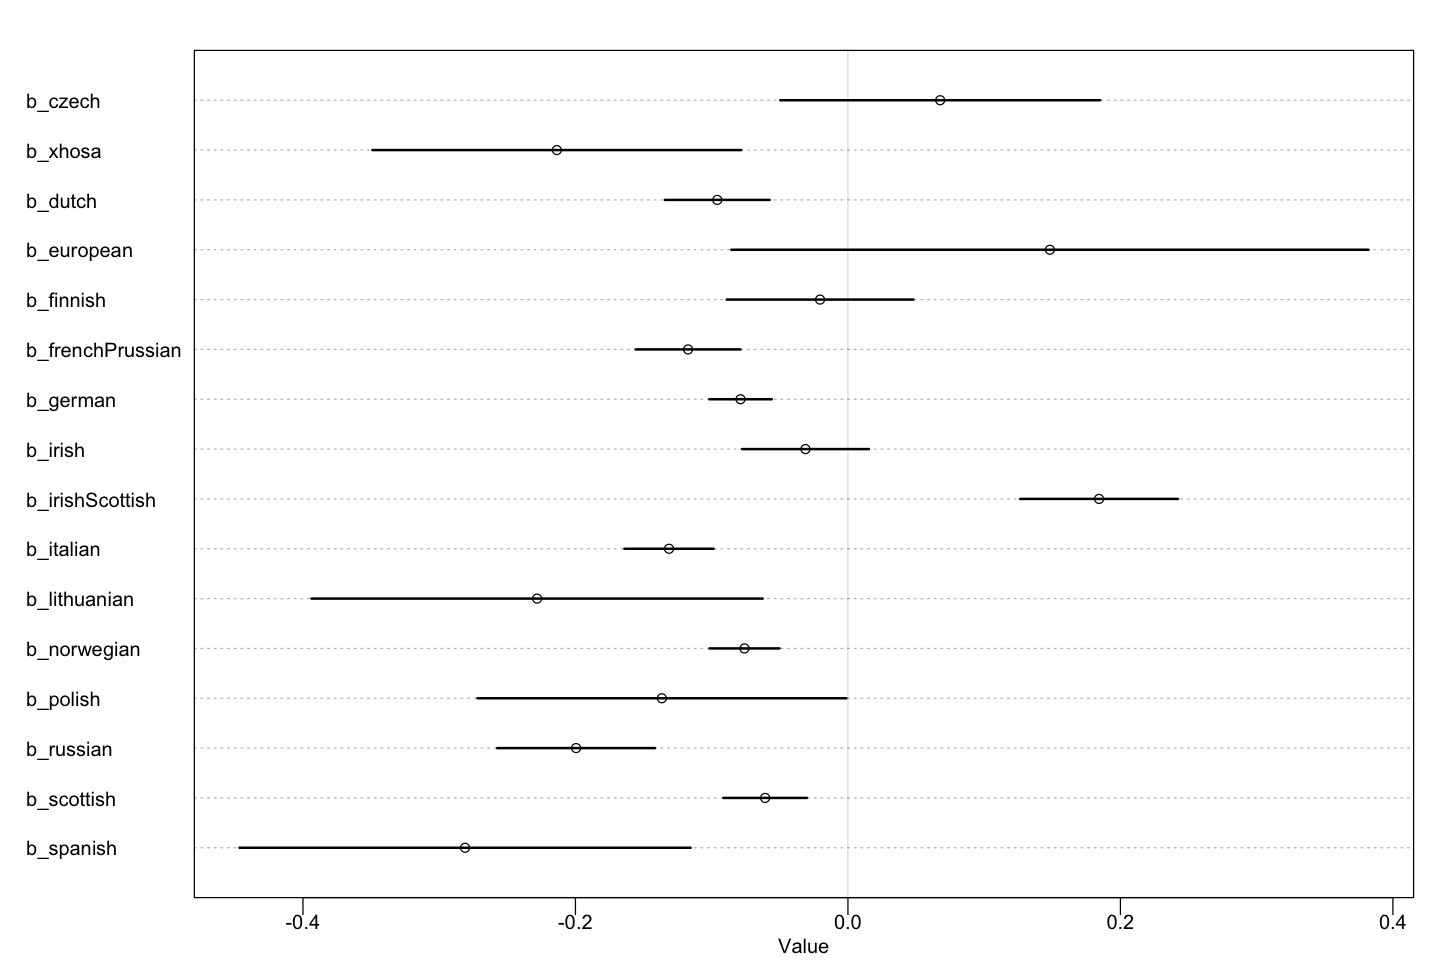

In [653]:
plot(
    precis(
        f1_countryOrigin,prob=.90,
        pars = c('b_czech',
                 'b_xhosa',
                 'b_dutch',
                 'b_european',
                 'b_finnish',
                 'b_frenchPrussian',
                 'b_german',
                 'b_irish',
                 'b_irishScottish',
                 'b_italian',
                 'b_lithuanian',
                 'b_norwegian',
                 'b_polish',
                 'b_russian',
                 'b_scottish',
                 'b_spanish')
    )
)

In [594]:
#Check class, summary and distribution of docyear
class(df$religionNew)
summary(df$religionNew)

[1] "factor"

Catholic  Christian     Jewish     Mormon Protestant 
       220        274        106          3        312

In [645]:
# Make indicator variables
df$r_catholic <- as.numeric(df$religionNew=='Catholic')
df$r_christian <- as.numeric(df$religionNew=='Christian')
df$r_jewish <- as.numeric(df$religionNew=='Jewish')
df$r_mormon <- as.numeric(df$religionNew=='Mormon')
unique(df[c('religionNew',
            'r_catholic',
            'r_christian',
            'r_jewish',
            'r_mormon'
           )])

,religionNew,r_catholic,r_christian,r_jewish,r_mormon
1,Catholic,1,0,0,0
193,Jewish,0,0,1,0
229,Protestant,0,0,0,0
334,Christian,0,1,0,0
563,Mormon,0,0,0,1


In [655]:
# Define model
m1_religionNew <- alist(
    SentimentLTR ~ dnorm(mu,sigma),
    mu <- a + b_catholic*r_catholic + 
    b_christian*r_christian + 
    b_jewish*r_jewish +
    b_mormon*r_mormon,
    
    a ~ dnorm(0,0.5),
    
    b_catholic ~ dnorm(0,30),
    b_christian ~ dnorm(0,30),
    b_jewish ~ dnorm(0,30),
    b_mormon ~ dnorm(0,30),
    
    sigma ~ dunif(0,50)
)



In [656]:
f1_religionNew <- map(m1_religionNew,data=df)

In [657]:
precis(f1_religionNew, prob=.9)

             Mean StdDev  5.0% 95.0%
a            0.20   0.01  0.19  0.21
b_catholic  -0.07   0.01 -0.10 -0.05
b_christian -0.03   0.01 -0.05 -0.01
b_jewish    -0.09   0.02 -0.12 -0.06
b_mormon    -0.14   0.09 -0.29  0.00
sigma        0.15   0.00  0.15  0.16

#### Occupation

In [673]:
vars  <- c("SentimentLTR",
           "Agricultural", 
           "Industrial", 
           "Professional", 
           "Commercial", 
           "Social", 
           "Government",
          "Domestic")

In [674]:
summary(df[vars])

  SentimentLTR      Agricultural    Industrial      Professional   
 Min.   :-0.39615   Mode :logical   Mode :logical   Mode :logical  
 1st Qu.: 0.06321   FALSE:619       FALSE:804       FALSE:548      
 Median : 0.15328   TRUE :296       TRUE :111       TRUE :367      
 Mean   : 0.16264                                                  
 3rd Qu.: 0.24872                                                  
 Max.   : 0.90003                                                  
 Commercial        Social        Government       Domestic      
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:572       FALSE:410       FALSE:762       FALSE:770      
 TRUE :343       TRUE :505       TRUE :153       TRUE :145      
                                                                
                                                                
                                                                

In [675]:
# Converts logical to numeric class
occupations.n <- df[vars]
str(occupations.n)

'data.frame':	915 obs. of  8 variables:
 $ SentimentLTR: num  0.1711 0.2365 0.1137 0.0447 0.1413 ...
 $ Agricultural: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Industrial  : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Professional: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Commercial  : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Social      : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Government  : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Domestic    : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


In [676]:
occupations.n  <- numerizeLogical(occupations.n)
str(occupations.n)

'data.frame':	915 obs. of  8 variables:
 $ SentimentLTR: num  0.1711 0.2365 0.1137 0.0447 0.1413 ...
 $ Agricultural: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Industrial  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Professional: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Commercial  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Social      : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Government  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Domestic    : num  1 1 1 1 1 1 1 1 1 1 ...


In [694]:
occupations.n %>% # select variables to summarise
  summarise_each(funs(sum))

SentimentLTR,Agricultural,Industrial,Professional,Commercial,Social,Government,Domestic
148.8128,296,111,367,343,505,153,145


In [698]:
# Define model
m1_occupation <- alist(
    SentimentLTR ~ dnorm(mu,sigma),
    mu <- a + b_agricultural*Agricultural + 
    b_industrial*Industrial + 
    b_professional*Professional +
    b_commercial*Commercial +
    b_social*Social +
    b_government*Government +
    b_domestic*Domestic,
    
    a ~ dnorm(0,0.5),
    
    b_agricultural ~ dnorm(0,30),
    b_industrial ~ dnorm(0,30),
    b_professional ~ dnorm(0,30),
    b_commercial ~ dnorm(0,30),
    b_social ~ dnorm(0,30),
    b_government ~ dnorm(0,30),
    b_domestic ~ dnorm(0,30),
    
    sigma ~ dunif(0,50)
)



In [699]:
f1_occupation <- map(m1_occupation,data=occupations.n)

In [700]:
precis(f1_occupation, prob=.9)

                Mean StdDev  5.0% 95.0%
a               0.07   0.02  0.05  0.10
b_agricultural  0.11   0.01  0.08  0.13
b_industrial   -0.01   0.02 -0.04  0.02
b_professional  0.04   0.02  0.01  0.07
b_commercial    0.04   0.02  0.01  0.06
b_social        0.02   0.02 -0.01  0.05
b_government    0.03   0.02  0.00  0.07
b_domestic      0.03   0.02  0.00  0.06
sigma           0.14   0.00  0.14  0.15

#### Topics

In [723]:
#Check class, summary and distribution of docyear
class(df$topicNumber)
summary(df$topicNumber)

[1] "factor"

0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 38  30  52  54  43  66  21  31  18  25  30 138  14  14  88  30  30  94  37  29 
 20 
 33

Code below adapted from file:///Users/alaynemoody/Dropbox/SOCI620_Resources/20200310_PM_Code17.html

### Topics

In [724]:
table(df$topicNumber)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 38  30  52  54  43  66  21  31  18  25  30 138  14  14  88  30  30  94  37  29 
 20 
 33 

$$letterTopics_i \sim Cat(softmax(topic_{ai}, topic_{bi}, ... topic_{ki})$$
$$topic_{ai} = 0$$
$$topic_{bi} = \alpha_{b} + \beta_{b}x_i $$
$$topic_{ci} = \alpha_{c} + \beta_{c}x_i$$
$$...$$
$$topic_{ki} = \alpha_{k} + \beta_{k}x_i$$
$$\alpha_b, \alpha_c, ... \alpha_k \sim Norm(0,2)$$
$$\beta_b, \beta_c, ... \beta_k \sim Norm(0,3)$$

In [894]:
sample  <- sample_n(df, 10)

In [725]:
df$topicNumber  <- as.factor(df$topicNumber)
table(df$topicNumber)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 38  30  52  54  43  66  21  31  18  25  30 138  14  14  88  30  30  94  37  29 
 20 
 33 

#### Year of Writing

In [753]:
m2_docyear <- alist(
  topicNumber ~ dcategorical(softmax(0,
                                    t_urbanPlaces, 
                                      t_nursing,
                                      t_correspondence,
                                      t_education,
                                      t_recollection,
                                      t_transition,
                                      t_settlement,
                                      t_authority,
                                      t_familyFriends,
                                      t_religion,
                                      t_dailyLife,
                                      t_ruralPlaces,
                                      t_essentials,
                                      t_farming,
                                      t_mindBodySpirit,
                                      t_pioneers,
                                      t_newsEvents,
                                      t_finances,
                                      t_modernization,
                                      t_money)),
    t_urbanPlaces <- a_urbanPlaces + b_urbanPlaces*docyear.s,
    t_nursing <- a_nursing + b_nursing*docyear.s,
    t_correspondence <- a_correspondence + b_correspondence*docyear.s, 
    t_education <- a_education + b_education*docyear.s, 
    t_recollection <- a_recollection + b_recollection*docyear.s, 
    t_transition <- a_transition + b_transition*docyear.s, 
    t_settlement <- a_settlement + b_settlement*docyear.s, 
    t_authority <- a_authority + b_authority*docyear.s, 
    t_familyFriends <- a_familyFriends + b_familyFriends*docyear.s, 
    t_religion <- a_religion + b_religion*docyear.s, 
    t_dailyLife <- a_dailyLife + b_dailyLife*docyear.s, 
    t_ruralPlaces <- a_ruralPlaces + b_ruralPlaces*docyear.s, 
    t_essentials <- a_essentials + b_essentials*docyear.s, 
    t_farming <- a_farming + b_farming*docyear.s, 
    t_mindBodySpirit <- a_mindBodySpirit + b_mindBodySpirit*docyear.s, 
    t_pioneers <- a_pioneers + b_pioneers*docyear.s, 
    t_newsEvents <- a_newsEvents + b_newsEvents*docyear.s, 
    t_finances <- a_finances + b_finances*docyear.s, 
    t_modernization <- a_modernization + b_modernization*docyear.s, 
    t_money <- a_money + b_money*docyear.s,
  
    c(a_urbanPlaces, 
    a_nursing,
    a_correspondence,
    a_education,
    a_recollection,
    a_transition,
    a_settlement,
    a_authority,
    a_familyFriends,
    a_religion,
    a_dailyLife, 
    a_ruralPlaces,
    a_essentials,
    a_farming,
    a_mindBodySpirit,
    a_pioneers,
    a_newsEvents,
    a_finances,
    a_modernization,
    a_money) ~ dnorm(0,2),

    c(b_urbanPlaces, 
    b_nursing,
    b_correspondence,
    b_education,
    b_recollection,
    b_transition,
    b_settlement,
    b_authority,
    b_familyFriends,
    b_religion,
    b_dailyLife, 
    b_ruralPlaces,
    b_essentials,
    b_farming,
    b_mindBodySpirit,
    b_pioneers,
    b_newsEvents,
    b_finances,
    b_modernization,
    b_money) ~ dnorm(0,3)
)

#(0219 Code 7, 2015 McElreath 10.58)

In [727]:
st <- list(a_urbanPlaces = 0, 
    a_nursing = 0,
    a_correspondence = 0,
    a_education = 0,
    a_recollection = 0,
    a_transition = 0,
    a_settlement = 0,
    a_authority = 0,
    a_familyFriends = 0,
    a_religion = 0,
    a_dailyLife = 0, 
    a_ruralPlaces = 0,
    a_essentials = 0,
    a_farming = 0,
    a_mindBodySpirit = 0,
    a_pioneers = 0,
    a_newsEvents = 0,
    a_finances = 0,
    a_modernization = 0,
    a_money = 0,
    b_urbanPlaces = 0, 
    b_nursing = 0,
    b_correspondence = 0,
    b_education = 0,
    b_recollection = 0,
    b_transition = 0,
    b_settlement = 0,
    b_authority = 0,
    b_familyFriends = 0,
    b_religion = 0,
    b_dailyLife = 0, 
    b_ruralPlaces = 0,
    b_essentials = 0,
    b_farming = 0,
    b_mindBodySpirit = 0,
    b_pioneers = 0,
    b_newsEvents = 0,
    b_finances = 0,
    b_modernization = 0,
    b_money = 0)

In [729]:
f2_docyear <- map(m2_docyear,data=df, start = st)
precis(f2_docyear,prob=.9)

                  Mean StdDev  5.0% 95.0%
a_urbanPlaces    -0.22   0.26 -0.65  0.20
a_nursing         0.09   0.24 -0.31  0.49
a_correspondence  0.45   0.22  0.10  0.80
a_education      -0.03   0.25 -0.44  0.38
a_recollection    0.66   0.21  0.32  1.00
a_transition     -0.53   0.28 -0.99 -0.07
a_settlement     -1.45   0.40 -2.12 -0.79
a_authority      -0.62   0.29 -1.09 -0.16
a_familyFriends  -0.35   0.27 -0.79  0.08
a_religion       -0.12   0.25 -0.52  0.28
a_dailyLife       1.39   0.19  1.08  1.70
a_ruralPlaces    -0.92   0.32 -1.44 -0.39
a_essentials     -0.96   0.33 -1.50 -0.42
a_farming         0.70   0.21  0.35  1.05
a_mindBodySpirit -0.15   0.25 -0.56  0.26
a_pioneers       -0.12   0.25 -0.53  0.28
a_newsEvents      0.97   0.20  0.65  1.30
a_finances       -0.49   0.29 -0.98 -0.01
a_modernization  -0.17   0.25 -0.58  0.24
a_money          -0.02   0.24 -0.42  0.37
b_urbanPlaces     1.04   0.27  0.59  1.49
b_nursing         1.44   0.24  1.04  1.84
b_correspondence  0.72   0.24  0.3

In [901]:
# get the predicted coefficients
cf <- coef(f2_docyear)
cf

a_urbanPlaces        a_nursing a_correspondence      a_education 
     -0.22275797       0.09348839       0.45098606      -0.02901951 
  a_recollection     a_transition     a_settlement      a_authority 
      0.65963748      -0.52969264      -1.45320598      -0.62497849 
 a_familyFriends       a_religion      a_dailyLife    a_ruralPlaces 
     -0.35266235      -0.11999736       1.39028729      -0.91736193 
    a_essentials        a_farming a_mindBodySpirit       a_pioneers 
     -0.95766624       0.70097952      -0.14968316      -0.12328942 
    a_newsEvents       a_finances  a_modernization          a_money 
      0.97073093      -0.49427877      -0.16744106      -0.02478594 
   b_urbanPlaces        b_nursing b_correspondence      b_education 
      1.03644402       1.43884913       0.71633323       1.34407440 
  b_recollection     b_transition     b_settlement      b_authority 
      0.39758795       0.12878286      -1.40803860       0.44157927 
 b_familyFriends       b_religion      b_dailyLife    b_ruralPlaces 
      0.89367962       0.56419768       0.34086410       0.15583586 
    b_essentials        b_farming b_mindBodySpirit       b_pioneers 
      0.02917763      -0.29535194       0.23875258       0.41837238 
    b_newsEvents       b_finances  b_modernization          b_money 
      0.87541230       1.72989030       0.71408856       0.52828970

In [952]:
tminus1 <- c(0,
        cf['a_urbanPlaces'] + cf['b_urbanPlaces']*-1,
        cf['a_nursing'] + cf['b_nursing']*-1,
        cf['a_correspondence'] + cf['b_correspondence']*-1,
        cf['a_education'] + cf['b_education']*-1,
        cf['a_recollection'] + cf['b_recollection']*-1,
        cf['a_transition'] + cf['b_transition']*-1,
        cf['a_settlement'] + cf['b_settlement']*-1,
        cf['a_authority'] + cf['b_authority']*-1,
        cf['a_familyFriends'] + cf['b_familyFriends']*-1,
        cf['a_religion'] + cf['b_religion']*-1,
        cf['a_dailyLife'] + cf['b_dailyLife']*-1,
        cf['a_ruralPlaces'] + cf['b_ruralPlaces']*-1,
        cf['a_essentials'] + cf['b_essentials']*-1,
        cf['a_farming'] + cf['b_farming']*-1,
        cf['a_mindBodySpirit'] + cf['b_mindBodySpirit']*-1,
        cf['a_pioneers'] + cf['b_pioneers']*-1,
        cf['a_newsEvents'] + cf['b_newsEvents']*-1,
        cf['a_finances'] + cf['b_finances']*-1,
        cf['a_modernization'] + cf['b_modernization']*-1,
        cf['a_money'] + cf['b_money']*-1       
)

In [953]:
pminus1 <- softmax(tminus1[1],tminus1[2],tminus1[3],tminus1[4], tminus1[5], tminus1[6], tminus1[7], tminus1[8], tminus1[9], tminus1[10], tminus1[11], tminus1[12], tminus1[13], tminus1[14], tminus1[15], tminus1[16], tminus1[17], tminus1[18], tminus1[19], tminus1[20], tminus1[21])

In [954]:
sum(pminus1)

[1] 1

In [917]:
t0 <- c(0,
        cf['a_urbanPlaces'] + cf['b_urbanPlaces']*0,
        cf['a_nursing'] + cf['b_nursing']*0,
        cf['a_correspondence'] + cf['b_correspondence']*0,
        cf['a_education'] + cf['b_education']*0,
        cf['a_recollection'] + cf['b_recollection']*0,
        cf['a_transition'] + cf['b_transition']*0,
        cf['a_settlement'] + cf['b_settlement']*0,
        cf['a_authority'] + cf['b_authority']*0,
        cf['a_familyFriends'] + cf['b_familyFriends']*0,
        cf['a_religion'] + cf['b_religion']*0,
        cf['a_dailyLife'] + cf['b_dailyLife']*0,
        cf['a_ruralPlaces'] + cf['b_ruralPlaces']*0,
        cf['a_essentials'] + cf['b_essentials']*0,
        cf['a_farming'] + cf['b_farming']*0,
        cf['a_mindBodySpirit'] + cf['b_mindBodySpirit']*0,
        cf['a_pioneers'] + cf['b_pioneers']*0,
        cf['a_newsEvents'] + cf['b_newsEvents']*0,
        cf['a_finances'] + cf['b_finances']*0,
        cf['a_modernization'] + cf['b_modernization']*0,
        cf['a_money'] + cf['b_money']*0       
)

In [918]:
p0 <- softmax(t0[1],t0[2],t0[3],t0[4], t0[5], t0[6], t0[7], t0[8], t0[9], t0[10], t0[11], t0[12], t0[13], t0[14], t0[15], t0[16], t0[17], t0[18], t0[19], t0[20], t0[21])

In [955]:
sum(p0)

[1] 1

In [919]:
t1 <- c(0,
        cf['a_urbanPlaces'] + cf['b_urbanPlaces']*1,
        cf['a_nursing'] + cf['b_nursing']*1,
        cf['a_correspondence'] + cf['b_correspondence']*1,
        cf['a_education'] + cf['b_education']*1,
        cf['a_recollection'] + cf['b_recollection']*1,
        cf['a_transition'] + cf['b_transition']*1,
        cf['a_settlement'] + cf['b_settlement']*1,
        cf['a_authority'] + cf['b_authority']*1,
        cf['a_familyFriends'] + cf['b_familyFriends']*1,
        cf['a_religion'] + cf['b_religion']*1,
        cf['a_dailyLife'] + cf['b_dailyLife']*1,
        cf['a_ruralPlaces'] + cf['b_ruralPlaces']*1,
        cf['a_essentials'] + cf['b_essentials']*1,
        cf['a_farming'] + cf['b_farming']*1,
        cf['a_mindBodySpirit'] + cf['b_mindBodySpirit']*1,
        cf['a_pioneers'] + cf['b_pioneers']*1,
        cf['a_newsEvents'] + cf['b_newsEvents']*1,
        cf['a_finances'] + cf['b_finances']*1,
        cf['a_modernization'] + cf['b_modernization']*1,
        cf['a_money'] + cf['b_money']*1       
)

In [920]:
p1 <- softmax(t1[1],t1[2],t1[3],t1[4], t1[5], t1[6], t1[7], t1[8], t1[9], t1[10], t1[11], t1[12], t1[13], t1[14], t1[15], t1[16], t1[17], t1[18], t1[19], t1[20], t1[21])

In [956]:
sum(p1)

[1] 1

In [957]:
names(pminus1) <- c('Shipboard',
               "Urban Places",
               "Nursing",
               "Correspondence",
               "Education",
               "Recollection",
               "Transition",
               "Settlement",
               "Authority",
               "Family and Friends",
               "Religion",
               "Daily Life",
               "Rural Places",
               "Essentials",
               "Farming",
               "Mind, Body and Spirit",
               "Pioneers",
               "News and Events",
               "Finances",
               "Modernization",
               "Money")

In [965]:
topicVisMinus1  <- t(data.frame(as.list(pminus1)))
colnames(topicVisMinus1)  <-  "a"
topicVisMinus1

,a
Shipboard,0.061689229
Urban.Places,0.017512368
Nursing,0.016066697
Correspondence,0.047311916
Education,0.015627238
Recollection,0.080170761
Transition,0.031932805
Settlement,0.058964877
Authority,0.021232894
Family.and.Friends,0.017739032


In [959]:
names(p0) <- c('Shipboard',
               "Urban Places",
               "Nursing",
               "Correspondence",
               "Education",
               "Recollection",
               "Transition",
               "Settlement",
               "Authority",
               "Family and Friends",
               "Religion",
               "Daily Life",
               "Rural Places",
               "Essentials",
               "Farming",
               "Mind, Body and Spirit",
               "Pioneers",
               "News and Events",
               "Finances",
               "Modernization",
               "Money")

In [966]:
topicVis0  <- t(data.frame(as.list(p0)))
colnames(topicVis0)  <-  "b"
topicVis0

,b
Shipboard,0.041749162
Urban.Places,0.033412210
Nursing,0.045840490
Correspondence,0.065540314
Education,0.040555032
Recollection,0.080746680
Transition,0.024581318
Settlement,0.009761767
Authority,0.022347197
Family.and.Friends,0.029341915


In [967]:
topicVis1  <- t(data.frame(as.list(p1)))
colnames(topicVis1)  <-  "c"
topicVis1

,c
Shipboard,0.021672274
Urban.Places,0.048897184
Nursing,0.100320622
Correspondence,0.069640970
Education,0.080728256
Recollection,0.062380903
Transition,0.014514149
Settlement,0.001239601
Authority,0.018040776
Family.and.Friends,0.037227623


In [908]:
colnames(topicVis)  <-  "Probability"
topicVis

,Probability
Shipboard,0.025089469
Urban.Places,0.056607091
Nursing,0.027548183
Correspondence,0.080621671
Education,0.024371848
Recollection,0.072216867
Transition,0.016802680
Settlement,0.001435056
Authority,0.020885372
Family.and.Friends,0.043097521


In [968]:
topicVisMinus1 <- as.data.frame(topicVisMinus1)
topicVis0 <- as.data.frame(topicVis0)
topicVis1 <- as.data.frame(topicVis1)

In [976]:
topicVis <- cbind(topicVisMinus1, topicVis0)
topicVis  <- cbind(topicVis, topicVis1)
colnames(topicVis)  <- c("1844", "1865", "1886")
round(topicVis,digits = 2)

,1844,1865,1886
Shipboard,0.06,0.04,0.02
Urban.Places,0.02,0.03,0.05
Nursing,0.02,0.05,0.10
Correspondence,0.05,0.07,0.07
Education,0.02,0.04,0.08
Recollection,0.08,0.08,0.06
Transition,0.03,0.02,0.01
Settlement,0.06,0.01,0.00
Authority,0.02,0.02,0.02
Family.and.Friends,0.02,0.03,0.04


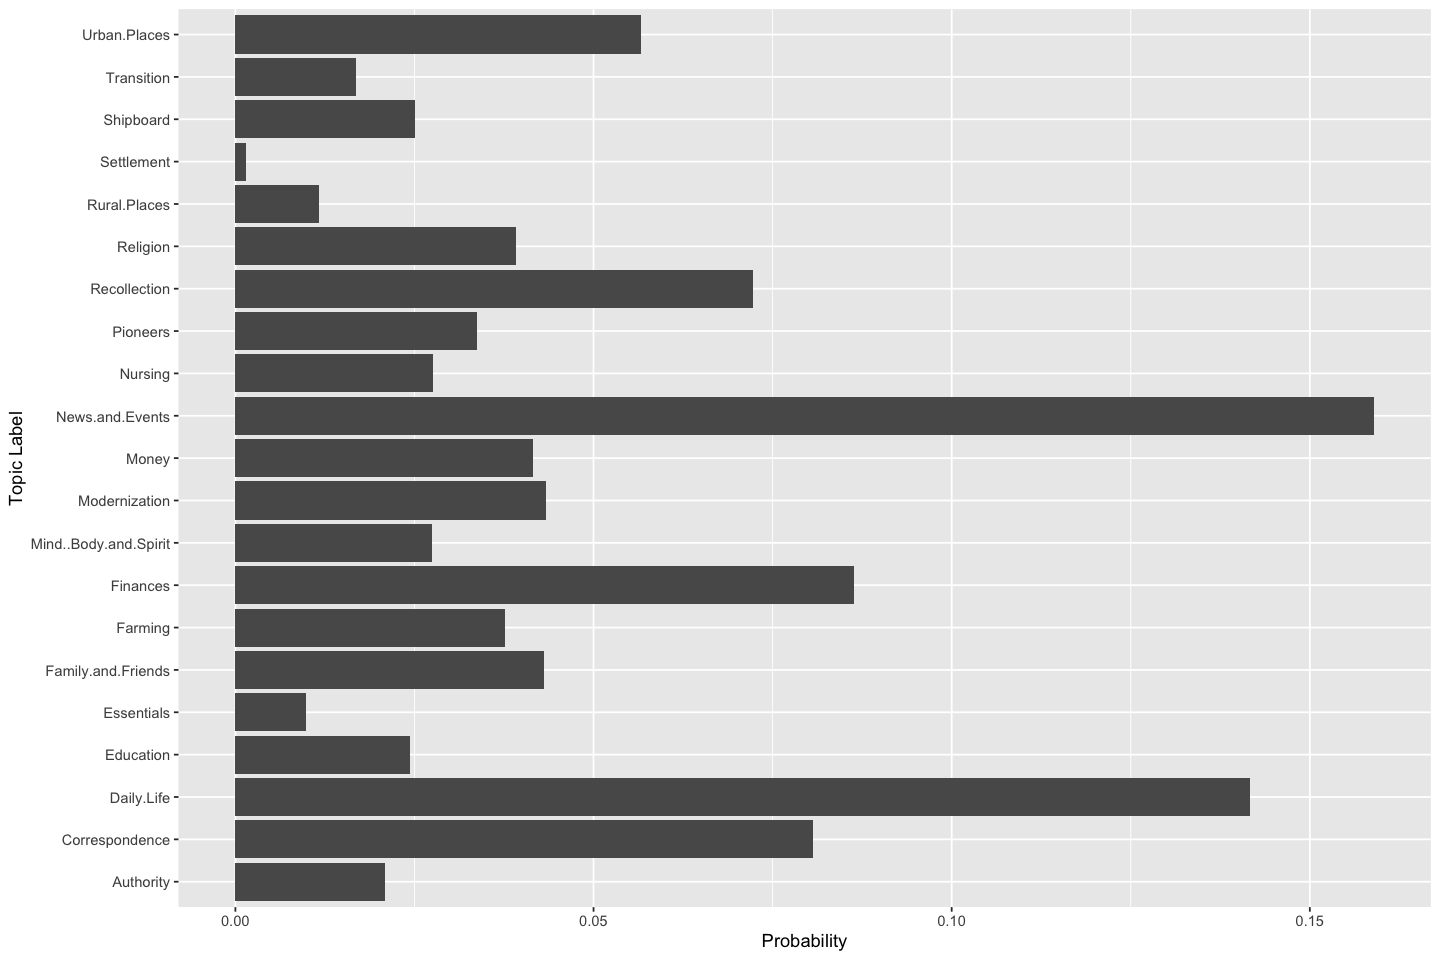

In [910]:
# Barplot
p  <- ggplot(topicVis, aes(x=rownames(topicVis), y=Probability)) + 
  geom_bar(stat = "identity") +
  coord_flip() + xlab("Topic Label")
p

In [739]:
ggsave("20210202_AM_LetterTopics-DocYear.png")

Saving 7 x 7 in image



#### Years since migration

In [756]:
m2_sinceMigration <- alist(
  topicNumber ~ dcategorical(softmax(0,
                                    t_urbanPlaces, 
                                      t_nursing,
                                      t_correspondence,
                                      t_education,
                                      t_recollection,
                                      t_transition,
                                      t_settlement,
                                      t_authority,
                                      t_familyFriends,
                                      t_religion,
                                      t_dailyLife,
                                      t_ruralPlaces,
                                      t_essentials,
                                      t_farming,
                                      t_mindBodySpirit,
                                      t_pioneers,
                                      t_newsEvents,
                                      t_finances,
                                      t_modernization,
                                      t_money)),
    t_urbanPlaces <- a_urbanPlaces + b_urbanPlaces*sinceMigration.s,
    t_nursing <- a_nursing + b_nursing*sinceMigration.s,
    t_correspondence <- a_correspondence + b_correspondence*sinceMigration.s, 
    t_education <- a_education + b_education*sinceMigration.s, 
    t_recollection <- a_recollection + b_recollection*sinceMigration.s, 
    t_transition <- a_transition + b_transition*sinceMigration.s, 
    t_settlement <- a_settlement + b_settlement*sinceMigration.s, 
    t_authority <- a_authority + b_authority*sinceMigration.s, 
    t_familyFriends <- a_familyFriends + b_familyFriends*sinceMigration.s, 
    t_religion <- a_religion + b_religion*sinceMigration.s, 
    t_dailyLife <- a_dailyLife + b_dailyLife*sinceMigration.s, 
    t_ruralPlaces <- a_ruralPlaces + b_ruralPlaces*sinceMigration.s, 
    t_essentials <- a_essentials + b_essentials*sinceMigration.s, 
    t_farming <- a_farming + b_farming*sinceMigration.s, 
    t_mindBodySpirit <- a_mindBodySpirit + b_mindBodySpirit*sinceMigration.s, 
    t_pioneers <- a_pioneers + b_pioneers*sinceMigration.s, 
    t_newsEvents <- a_newsEvents + b_newsEvents*sinceMigration.s, 
    t_finances <- a_finances + b_finances*sinceMigration.s, 
    t_modernization <- a_modernization + b_modernization*sinceMigration.s, 
    t_money <- a_money + b_money*sinceMigration.s,
  
    c(a_urbanPlaces, 
    a_nursing,
    a_correspondence,
    a_education,
    a_recollection,
    a_transition,
    a_settlement,
    a_authority,
    a_familyFriends,
    a_religion,
    a_dailyLife, 
    a_ruralPlaces,
    a_essentials,
    a_farming,
    a_mindBodySpirit,
    a_pioneers,
    a_newsEvents,
    a_finances,
    a_modernization,
    a_money) ~ dnorm(0,2),

    c(b_urbanPlaces, 
    b_nursing,
    b_correspondence,
    b_education,
    b_recollection,
    b_transition,
    b_settlement,
    b_authority,
    b_familyFriends,
    b_religion,
    b_dailyLife, 
    b_ruralPlaces,
    b_essentials,
    b_farming,
    b_mindBodySpirit,
    b_pioneers,
    b_newsEvents,
    b_finances,
    b_modernization,
    b_money) ~ dnorm(0,3)
)

#(0219 Code 7, 2015 McElreath 10.58)

In [ ]:
st <- list(a_urbanPlaces = 0, 
    a_nursing = 0,
    a_correspondence = 0,
    a_education = 0,
    a_recollection = 0,
    a_transition = 0,
    a_settlement = 0,
    a_authority = 0,
    a_familyFriends = 0,
    a_religion = 0,
    a_dailyLife = 0, 
    a_ruralPlaces = 0,
    a_essentials = 0,
    a_farming = 0,
    a_mindBodySpirit = 0,
    a_pioneers = 0,
    a_newsEvents = 0,
    a_finances = 0,
    a_modernization = 0,
    a_money = 0,
    
    b_urbanPlaces = 0, 
    b_nursing = 0,
    b_correspondence = 0,
    b_education = 0,
    b_recollection = 0,
    b_transition = 0,
    b_settlement = 0,
    b_authority = 0,
    b_familyFriends = 0,
    b_religion = 0,
    b_dailyLife = 0, 
    b_ruralPlaces = 0,
    b_essentials = 0,
    b_farming = 0,
    b_mindBodySpirit = 0,
    b_pioneers = 0,
    b_newsEvents = 0,
    b_finances = 0,
    b_modernization = 0,
    b_money = 0)

In [757]:
f2_sinceMigration <- map(m2_sinceMigration,data=sample, start = st)

In [758]:
precis(f2_sinceMigration,prob=.9)

                  Mean StdDev  5.0% 95.0%
a_urbanPlaces     0.89   1.14 -0.98  2.76
a_nursing        -0.63   1.60 -3.25  2.00
a_correspondence -0.63   1.60 -3.25  2.00
a_education       0.50   1.18 -1.43  2.44
a_recollection   -0.63   1.60 -3.25  2.00
a_transition     -0.63   1.60 -3.25  2.00
a_settlement     -0.63   1.60 -3.25  2.00
a_authority      -0.63   1.60 -3.25  2.00
a_familyFriends   0.84   1.14 -1.04  2.72
a_religion       -0.63   1.60 -3.25  2.00
a_dailyLife       2.24   0.85  0.85  3.63
a_ruralPlaces    -0.63   1.60 -3.25  2.00
a_essentials     -0.63   1.60 -3.25  2.00
a_farming         1.11   1.12 -0.73  2.95
a_mindBodySpirit  0.50   1.18 -1.43  2.44
a_pioneers       -0.63   1.60 -3.25  2.00
a_newsEvents     -0.74   1.43 -3.10  1.61
a_finances       -0.63   1.60 -3.25  2.00
a_modernization  -0.63   1.60 -3.25  2.00
a_money          -0.63   1.60 -3.25  2.00
b_urbanPlaces     0.23   2.28 -3.53  3.98
b_nursing        -0.24   2.81 -4.85  4.38
b_correspondence -0.24   2.81 -4.8

In [761]:
# get the predicted coefficients
cf <- coef(f2_sinceMigration)
cf

a_urbanPlaces        a_nursing a_correspondence      a_education 
       0.8913031       -0.6252120       -0.6252120        0.5047754 
  a_recollection     a_transition     a_settlement      a_authority 
      -0.6252120       -0.6252120       -0.6252120       -0.6252120 
 a_familyFriends       a_religion      a_dailyLife    a_ruralPlaces 
       0.8407015       -0.6252120        2.2379816       -0.6252120 
    a_essentials        a_farming a_mindBodySpirit       a_pioneers 
      -0.6252120        1.1065253        0.5047754       -0.6252120 
    a_newsEvents       a_finances  a_modernization          a_money 
      -0.7421449       -0.6252120       -0.6252120       -0.6252120 
   b_urbanPlaces        b_nursing b_correspondence      b_education 
       0.2273648       -0.2350083       -0.2350083        1.6886063 
  b_recollection     b_transition     b_settlement      b_authority 
      -0.2350083       -0.2350083       -0.2350083       -0.2350083 
 b_familyFriends       b_religion      b_dailyLife    b_ruralPlaces 
       0.5192419       -0.2350083       -1.1012615       -0.2350083 
    b_essentials        b_farming b_mindBodySpirit       b_pioneers 
      -0.2350083       -2.4558800        1.6886063       -0.2350083 
    b_newsEvents       b_finances  b_modernization          b_money 
       3.0024304       -0.2350083       -0.2350083       -0.2350083

In [762]:
t1 <- c(0,
        cf['a_urbanPlaces'] + cf['b_urbanPlaces'],
        cf['a_nursing'] + cf['b_nursing'],
        cf['a_correspondence'] + cf['b_correspondence'],
        cf['a_education'] + cf['b_education'],
        cf['a_recollection'] + cf['b_recollection'],
        cf['a_transition'] + cf['b_transition'],
        cf['a_settlement'] + cf['b_settlement'],
        cf['a_authority'] + cf['b_authority'],
        cf['a_familyFriends'] + cf['b_familyFriends'],
        cf['a_religion'] + cf['b_religion'],
        cf['a_dailyLife'] + cf['b_dailyLife'],
        cf['a_ruralPlaces'] + cf['b_ruralPlaces'],
        cf['a_essentials'] + cf['b_essentials'],
        cf['a_farming'] + cf['b_farming'],
        cf['a_mindBodySpirit'] + cf['b_mindBodySpirit'],
        cf['a_pioneers'] + cf['b_pioneers'],
        cf['a_newsEvents'] + cf['b_newsEvents'],
        cf['a_finances'] + cf['b_finances'],
        cf['a_modernization'] + cf['b_modernization'],
        cf['a_money'] + cf['b_money']       
)

In [763]:
p1 <- softmax(t1[1],t1[2],t1[3],t1[4], t1[5], t1[6], t1[7], t1[8], t1[9], t1[10], t1[11], t1[12], t1[13], t1[14], t1[15], t1[16], t1[17], t1[18], t1[19], t1[20], t1[21])

In [764]:
sum(p1)

[1] 1

In [766]:
names(p1) <- c('Shipboard',
               "Urban Places",
               "Nursing",
               "Correspondence",
               "Education",
               "Recollection",
               "Transition",
               "Settlement",
               "Authority",
               "Family and Friends",
               "Religion",
               "Daily Life",
               "Rural Places",
               "Essentials",
               "Farming",
               "Mind, Body and Spirit",
               "Pioneers",
               "News and Events",
               "Finances",
               "Modernization",
               "Money")

In [767]:
p1

Shipboard          Urban Places               Nursing 
          0.022548237           0.069015057           0.009539458 
       Correspondence             Education          Recollection 
          0.009539458           0.202155772           0.009539458 
           Transition            Settlement             Authority 
          0.009539458           0.009539458           0.009539458 
   Family and Friends              Religion            Daily Life 
          0.087847313           0.009539458           0.070272251 
         Rural Places            Essentials               Farming 
          0.009539458           0.009539458           0.005849184 
Mind, Body and Spirit              Pioneers       News and Events 
          0.202155772           0.009539458           0.216143467 
             Finances         Modernization                 Money 
          0.009539458           0.009539458           0.009539458

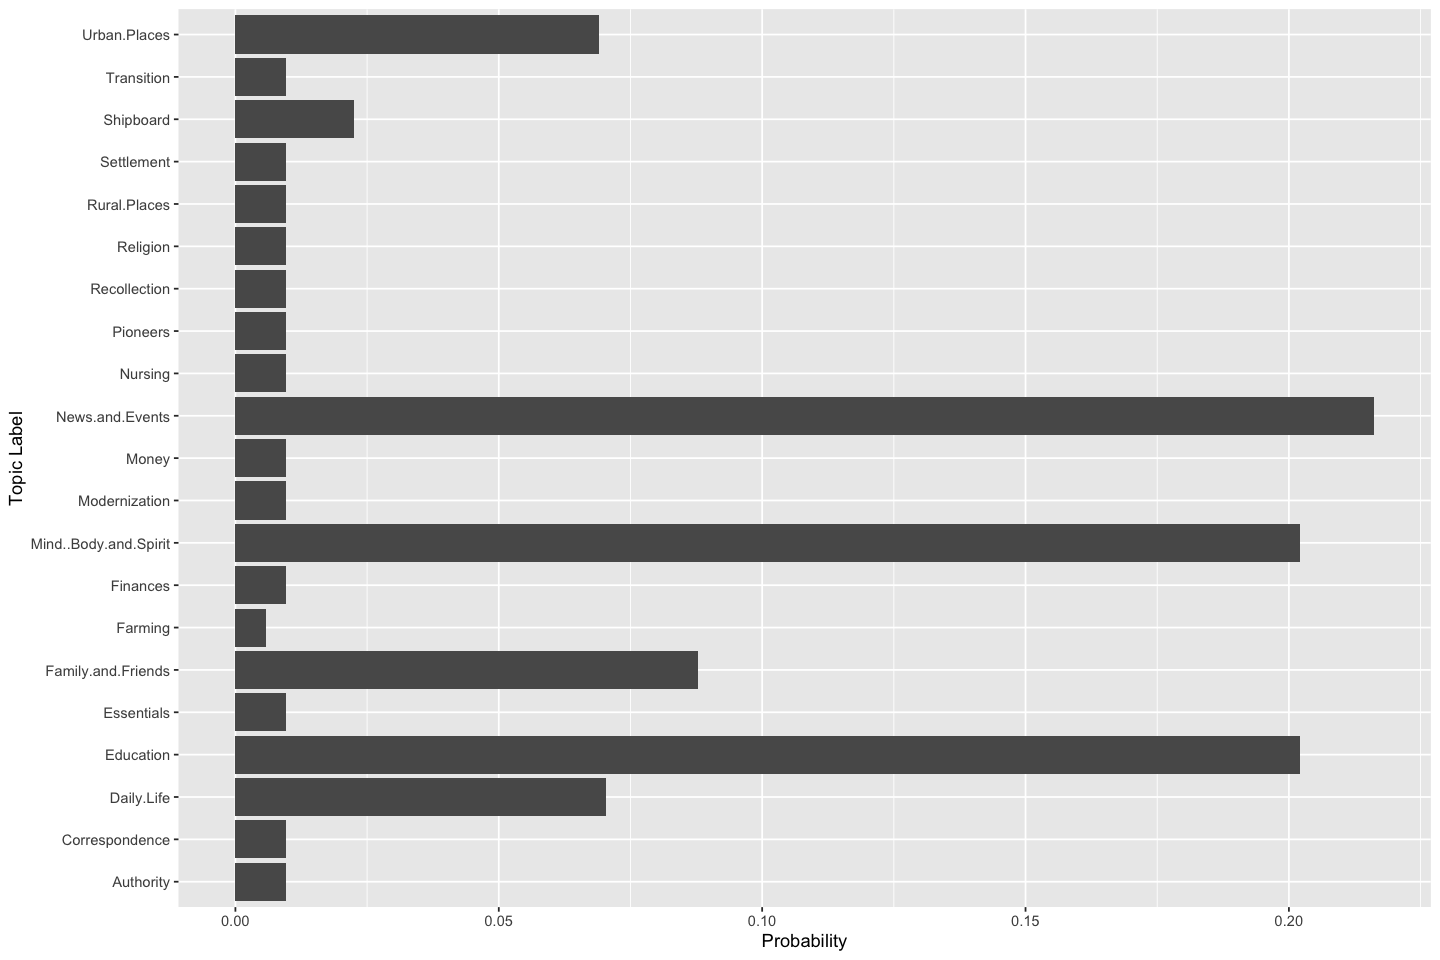

In [768]:
# Prep DF
topicVis  <- t(data.frame(as.list(p1)))
colnames(topicVis)  <-  "Probability"
topicVis <- as.data.frame(topicVis)

# Barplot
p  <- ggplot(topicVis, aes(x=rownames(topicVis), y=Probability)) + 
  geom_bar(stat = "identity") +
  coord_flip() + xlab("Topic Label")
p

#### Author Location

In [1042]:
sample  <- sample_n(df, 10)

In [1043]:
table(df$al_usa)
table(df$al_canada)
table(df$al_other)


  0   1 
434 481 


  0   1 
488 427 


  0   1 
908   7 

In [816]:
m2_authorLocation <- alist(
  topicNumber ~ dcategorical(softmax(0,
                                    t_urbanPlaces, 
                                      t_nursing,
                                      t_correspondence,
                                      t_education,
                                      t_recollection,
                                      t_transition,
                                      t_settlement,
                                      t_authority,
                                      t_familyFriends,
                                      t_religion,
                                      t_dailyLife,
                                      t_ruralPlaces,
                                      t_essentials,
                                      t_farming,
                                      t_mindBodySpirit,
                                      t_pioneers,
                                      t_newsEvents,
                                      t_finances,
                                      t_modernization,
                                      t_money)),
    t_urbanPlaces <- a_urbanPlaces + b_urbanPlacesUSA*al_usa + b_urbanPlacesOther*al_other,
    t_nursing <- a_nursing + b_nursingUSA*al_usa + b_nursingOther*al_other,
    t_correspondence <- a_correspondence + b_correspondenceUSA*al_usa + b_correspondenceOther*al_other, 
    t_education <- a_education + b_educationUSA*al_usa + b_educationOther*al_other, 
    t_recollection <- a_recollection + b_recollectionUSA*al_usa + b_recollectionOther*al_other, 
    t_transition <- a_transition + b_transitionUSA*al_usa + b_transitionOther*al_other, 
    t_settlement <- a_settlement + b_settlementUSA*al_usa + b_settlementOther*al_other, 
    t_authority <- a_authority + b_authorityUSA*al_usa + b_authorityOther*al_other, 
    t_familyFriends <- a_familyFriends + b_familyFriendsUSA*al_usa + b_familyFriendsOther*al_other, 
    t_religion <- a_religion + b_religionUSA*al_usa + b_religionOther*al_other, 
    t_dailyLife <- a_dailyLife + b_dailyLifeUSA*al_usa + b_dailyLifeOther*al_other, 
    t_ruralPlaces <- a_ruralPlaces + b_ruralPlacesUSA*al_usa + b_ruralPlacesOther*al_other, 
    t_essentials <- a_essentials + b_essentialsUSA*al_usa + b_essentialsOther*al_other, 
    t_farming <- a_farming + b_farmingUSA*al_usa + b_farmingOther*al_other, 
    t_mindBodySpirit <- a_mindBodySpirit + b_mindBodySpiritUSA*al_usa + b_mindBodySpiritOther*al_other, 
    t_pioneers <- a_pioneers + b_pioneersUSA*al_usa + b_pioneersOther*al_other, 
    t_newsEvents <- a_newsEvents + b_newsEventsUSA*al_usa + b_newsEventsOther*al_other, 
    t_finances <- a_finances + b_financesUSA*al_usa + b_financesOther*al_other, 
    t_modernization <- a_modernization + b_modernizationUSA*al_usa + b_modernizationOther*al_other, 
    t_money <- a_money + b_moneyUSA*al_usa + b_moneyOther*al_other,
  
    c(a_urbanPlaces, 
    a_nursing,
    a_correspondence,
    a_education,
    a_recollection,
    a_transition,
    a_settlement,
    a_authority,
    a_familyFriends,
    a_religion,
    a_dailyLife, 
    a_ruralPlaces,
    a_essentials,
    a_farming,
    a_mindBodySpirit,
    a_pioneers,
    a_newsEvents,
    a_finances,
    a_modernization,
    a_money) ~ dnorm(0,2),

    c(b_urbanPlacesUSA, 
    b_nursingUSA,
    b_correspondenceUSA,
    b_educationUSA,
    b_recollectionUSA,
    b_transitionUSA,
    b_settlementUSA,
    b_authorityUSA,
    b_familyFriendsUSA,
    b_religionUSA,
    b_dailyLifeUSA, 
    b_ruralPlacesUSA,
    b_essentialsUSA,
    b_farmingUSA,
    b_mindBodySpiritUSA,
    b_pioneersUSA,
    b_newsEventsUSA,
    b_financesUSA,
    b_modernizationUSA,
    b_moneyUSA,
      
    b_urbanPlacesOther, 
    b_nursingOther,
    b_correspondenceOther,
    b_educationOther,
    b_recollectionOther,
    b_transitionOther,
    b_settlementOther,
    b_authorityOther,
    b_familyFriendsOther,
    b_religionOther,
    b_dailyLifeOther, 
    b_ruralPlacesOther,
    b_essentialsOther,
    b_farmingOther,
    b_mindBodySpiritOther,
    b_pioneersOther,
    b_newsEventsOther,
    b_financesOther,
    b_modernizationOther,
    b_moneyOther) ~ dnorm(0,3)
)

#(0219 Code 7, 2015 McElreath 10.58)

In [772]:
st <- list(a_urbanPlaces = 0, 
    a_nursing = 0,
    a_correspondence = 0,
    a_education = 0,
    a_recollection = 0,
    a_transition = 0,
    a_settlement = 0,
    a_authority = 0,
    a_familyFriends = 0,
    a_religion = 0,
    a_dailyLife = 0, 
    a_ruralPlaces = 0,
    a_essentials = 0,
    a_farming = 0,
    a_mindBodySpirit = 0,
    a_pioneers = 0,
    a_newsEvents = 0,
    a_finances = 0,
    a_modernization = 0,
    a_money = 0,
    
    b_urbanPlacesUSA = 0, 
    b_nursingUSA = 0,
    b_correspondenceUSA = 0,
    b_educationUSA = 0,
    b_recollectionUSA = 0,
    b_transitionUSA = 0,
    b_settlementUSA = 0,
    b_authorityUSA = 0,
    b_familyFriendsUSA = 0,
    b_religionUSA = 0,
    b_dailyLifeUSA = 0, 
    b_ruralPlacesUSA = 0,
    b_essentialsUSA = 0,
    b_farmingUSA = 0,
    b_mindBodySpiritUSA = 0,
    b_pioneersUSA = 0,
    b_newsEventsUSA = 0,
    b_financesUSA = 0,
    b_modernizationUSA = 0,
    b_moneyUSA = 0,
    
    b_urbanPlacesOther = 0, 
    b_nursingOther = 0,
    b_correspondenceOther = 0,
    b_educationOther = 0,
    b_recollectionOther = 0,
    b_transitionOther = 0,
    b_settlementOther = 0,
    b_authorityOther = 0,
    b_familyFriendsOther = 0,
    b_religionOther = 0,
    b_dailyLifeOther = 0, 
    b_ruralPlacesOther = 0,
    b_essentialsOther = 0,
    b_farmingOther = 0,
    b_mindBodySpiritOther = 0,
    b_pioneersOther = 0,
    b_newsEventsOther = 0,
    b_financesOther = 0,
    b_modernizationOther = 0,
    b_moneyOther = 0)

In [819]:
f2_authorLocation <- map(m2_authorLocation,data=sample, start = st)

In [822]:
precis(f2_authorLocation,prob=.9)

                       Mean StdDev  5.0% 95.0%
a_urbanPlaces          1.51   1.06 -0.24  3.26
a_nursing             -0.51   1.65 -3.22  2.21
a_correspondence      -0.51   1.65 -3.22  2.21
a_education           -0.51   1.65 -3.22  2.21
a_recollection         2.07   0.95  0.51  3.63
a_transition          -0.51   1.65 -3.22  2.21
a_settlement          -0.51   1.65 -3.22  2.21
a_authority           -0.51   1.65 -3.22  2.21
a_familyFriends       -0.51   1.65 -3.22  2.21
a_religion            -0.51   1.65 -3.22  2.21
a_dailyLife            1.26   1.15 -0.63  3.15
a_ruralPlaces         -0.51   1.65 -3.22  2.21
a_essentials          -0.51   1.65 -3.22  2.21
a_farming              1.51   1.06 -0.24  3.26
a_mindBodySpirit       1.26   1.15 -0.63  3.15
a_pioneers            -0.51   1.65 -3.22  2.21
a_newsEvents           0.39   1.34 -1.82  2.59
a_finances            -0.51   1.65 -3.22  2.21
a_modernization       -0.51   1.65 -3.22  2.21
a_money               -0.51   1.65 -3.22  2.21
b_urbanPlaces

In [823]:
# get the predicted coefficients
cf <- coef(f2_authorLocation)
cf

a_urbanPlaces             a_nursing      a_correspondence 
            1.5063432            -0.5073833            -0.5073833 
          a_education        a_recollection          a_transition 
           -0.5073833             2.0669494            -0.5073833 
         a_settlement           a_authority       a_familyFriends 
           -0.5073833            -0.5073833            -0.5073833 
           a_religion           a_dailyLife         a_ruralPlaces 
           -0.5073833             1.2570107            -0.5073833 
         a_essentials             a_farming      a_mindBodySpirit 
           -0.5073833             1.5063432             1.2570107 
           a_pioneers          a_newsEvents            a_finances 
           -0.5073833             0.3887030            -0.5073833 
      a_modernization               a_money      b_urbanPlacesUSA 
           -0.5073833            -0.5073833             1.3760266 
         b_nursingUSA   b_correspondenceUSA        b_educationUSA 
           -0.2094686            -0.2094686            -0.2094686 
    b_recollectionUSA       b_transitionUSA       b_settlementUSA 
           -1.1089824            -0.2094686            -0.2094686 
       b_authorityUSA    b_familyFriendsUSA         b_religionUSA 
           -0.2094686            -0.2094686            -0.2094686 
       b_dailyLifeUSA      b_ruralPlacesUSA       b_essentialsUSA 
           -0.7266371            -0.2094686            -0.2094686 
         b_farmingUSA   b_mindBodySpiritUSA         b_pioneersUSA 
            1.3760266            -0.7266371            -0.2094686 
      b_newsEventsUSA         b_financesUSA    b_modernizationUSA 
            3.1594764            -0.2094686            -0.2094686 
           b_moneyUSA    b_urbanPlacesOther        b_nursingOther 
           -0.2094686             0.0000000             0.0000000 
b_correspondenceOther      b_educationOther   b_recollectionOther 
            0.0000000             0.0000000             0.0000000 
    b_transitionOther     b_settlementOther      b_authorityOther 
            0.0000000             0.0000000             0.0000000 
 b_familyFriendsOther       b_religionOther      b_dailyLifeOther 
            0.0000000             0.0000000             0.0000000 
   b_ruralPlacesOther     b_essentialsOther        b_farmingOther 
            0.0000000             0.0000000             0.0000000 
b_mindBodySpiritOther       b_pioneersOther     b_newsEventsOther 
            0.0000000             0.0000000             0.0000000 
      b_financesOther  b_modernizationOther          b_moneyOther 
            0.0000000             0.0000000             0.0000000

#### Author Location

In [ ]:
t1 <- c(0,
        cf['a_urbanPlaces'] + cf['b_urbanPlacesUSA'] + cf['b_urbanPlacesOther'],
        cf['a_nursing'] + cf['b_nursingUSA'] + cf['b_nursingOther'],
        cf['a_correspondence'] + cf['b_correspondenceUSA'] + cf['b_correspondenceOther'],
        cf['a_education'] + cf['b_educationUSA'] + cf['b_educationOther'],
        cf['a_recollection'] + cf['b_recollectionUSA'] + cf['b_recollectionOther'],
        cf['a_transition'] + cf['b_transitionUSA'] + cf['b_transitionOther'],
        cf['a_settlement'] + cf['b_settlementUSA'] + cf['b_settlementOther'],
        cf['a_authority'] + cf['b_authorityUSA'] + cf['b_authorityOther'],
        cf['a_familyFriends'] + cf['b_familyFriendsUSA'] + cf['b_familyFriendsOther'],
        cf['a_religion'] + cf['b_religionUSA'] + cf['b_religionOther'],
        cf['a_dailyLife'] + cf['b_dailyLifeUSA'] + cf['b_dailyLifeOther'],
        cf['a_ruralPlaces'] + cf['b_ruralPlacesUSA'] + cf['b_ruralPlacesOther'],
        cf['a_essentials'] + cf['b_essentialsUSA'] + cf['b_essentialsOther'],
        cf['a_farming'] + cf['b_farmingUSA'] + cf['b_farmingOther'],
        cf['a_mindBodySpirit'] + cf['b_mindBodySpiritUSA'] + cf['b_mindBodySpiritOther'],
        cf['a_pioneers'] + cf['b_pioneersUSA'] + cf['b_pioneersOther'],
        cf['a_newsEvents'] + cf['b_newsEventsUSA'] + cf['b_newsEventsOther'],
        cf['a_finances'] + cf['b_financesUSA'] + cf['b_financesOther'],
        cf['a_modernization'] + cf['b_modernizationUSA'] + cf['b_modernizationOther'],
        cf['a_money'] + cf['b_moneyUSA'] + cf['b_moneyOther']     
)

In [826]:
p1 <- softmax(t1[1],t1[2],t1[3],t1[4], t1[5], t1[6], t1[7], t1[8], t1[9], t1[10], t1[11], t1[12], t1[13], t1[14], t1[15], t1[16], t1[17], t1[18], t1[19], t1[20], t1[21])

In [827]:
sum(p1)

[1] 1

In [828]:
names(p1) <- c('Shipboard',
               "Urban Places",
               "Nursing",
               "Correspondence",
               "Education",
               "Recollection",
               "Transition",
               "Settlement",
               "Authority",
               "Family and Friends",
               "Religion",
               "Daily Life",
               "Rural Places",
               "Essentials",
               "Farming",
               "Mind, Body and Spirit",
               "Pioneers",
               "News and Events",
               "Finances",
               "Modernization",
               "Money")
p1

Shipboard          Urban Places               Nursing 
          0.011861746           0.211809750           0.005791937 
       Correspondence             Education          Recollection 
          0.005791937           0.005791937           0.030916364 
           Transition            Settlement             Authority 
          0.005791937           0.005791937           0.005791937 
   Family and Friends              Religion            Daily Life 
          0.005791937           0.005791937           0.020159833 
         Rural Places            Essentials               Farming 
          0.005791937           0.005791937           0.211809750 
Mind, Body and Spirit              Pioneers       News and Events 
          0.020159833           0.005791937           0.412195608 
             Finances         Modernization                 Money 
          0.005791937           0.005791937           0.005791937

In [830]:
# Prep DF
topicVis  <- t(data.frame(as.list(p1)))
colnames(topicVis)  <-  "Probability"
topicVis <- as.data.frame(topicVis)
topicVis

,Probability
Shipboard,0.011861746
Urban.Places,0.211809750
Nursing,0.005791937
Correspondence,0.005791937
Education,0.005791937
Recollection,0.030916364
Transition,0.005791937
Settlement,0.005791937
Authority,0.005791937
Family.and.Friends,0.005791937


In [839]:
topicVis$t1_USA <- c(0,
        cf['a_urbanPlaces'] + cf['b_urbanPlacesUSA']*1 + cf['b_urbanPlacesOther']*0,
        cf['a_nursing'] + cf['b_nursingUSA']*1 + cf['b_nursingOther']*0,
        cf['a_correspondence'] + cf['b_correspondenceUSA']*1 + cf['b_correspondenceOther']*0,
        cf['a_education'] + cf['b_educationUSA']*1 + cf['b_educationOther']*0,
        cf['a_recollection'] + cf['b_recollectionUSA']*1 + cf['b_recollectionOther']*0,
        cf['a_transition'] + cf['b_transitionUSA']*1 + cf['b_transitionOther']*0,
        cf['a_settlement'] + cf['b_settlementUSA']*1 + cf['b_settlementOther']*0,
        cf['a_authority'] + cf['b_authorityUSA']*1 + cf['b_authorityOther']*0,
        cf['a_familyFriends'] + cf['b_familyFriendsUSA']*1 + cf['b_familyFriendsOther']*0,
        cf['a_religion'] + cf['b_religionUSA']*1 + cf['b_religionOther']*0,
        cf['a_dailyLife'] + cf['b_dailyLifeUSA']*1 + cf['b_dailyLifeOther']*0,
        cf['a_ruralPlaces'] + cf['b_ruralPlacesUSA']*1 + cf['b_ruralPlacesOther']*0,
        cf['a_essentials'] + cf['b_essentialsUSA']*1 + cf['b_essentialsOther']*0,
        cf['a_farming'] + cf['b_farmingUSA']*1 + cf['b_farmingOther']*0,
        cf['a_mindBodySpirit'] + cf['b_mindBodySpiritUSA']*1 + cf['b_mindBodySpiritOther']*0,
        cf['a_pioneers'] + cf['b_pioneersUSA']*1 + cf['b_pioneersOther']*0,
        cf['a_newsEvents'] + cf['b_newsEventsUSA']*1 + cf['b_newsEventsOther']*0,
        cf['a_finances'] + cf['b_financesUSA']*1 + cf['b_financesOther']*0,
        cf['a_modernization'] + cf['b_modernizationUSA']*1 + cf['b_modernizationOther']*0,
        cf['a_money'] + cf['b_moneyUSA']*1 + cf['b_moneyOther']*0     
)

In [849]:
topicVis$p1_USA <- softmax(topicVis$t1_USA[1],
                       topicVis$t1_USA[2],
                       topicVis$t1_USA[3],
                       topicVis$t1_USA[4], 
                       topicVis$t1_USA[5], 
                       topicVis$t1_USA[6], 
                       topicVis$t1_USA[7], 
                       topicVis$t1_USA[8], 
                       topicVis$t1_USA[9], 
                       topicVis$t1_USA[10], 
                       topicVis$t1_USA[11], 
                       topicVis$t1_USA[12], 
                       topicVis$t1_USA[13], 
                       topicVis$t1_USA[14], 
                       topicVis$t1_USA[15], 
                       topicVis$t1_USA[16], 
                       topicVis$t1_USA[17], 
                       topicVis$t1_USA[18], 
                       topicVis$t1_USA[19], 
                       topicVis$t1_USA[20], 
                       topicVis$t1_USA[21])

In [850]:
topicVis$t1_Other <- c(0,
        cf['a_urbanPlaces'] + cf['b_urbanPlacesUSA']*0 + cf['b_urbanPlacesOther']*1,
        cf['a_nursing'] + cf['b_nursingUSA']*0 + cf['b_nursingOther']*1,
        cf['a_correspondence'] + cf['b_correspondenceUSA']*0 + cf['b_correspondenceOther']*1,
        cf['a_education'] + cf['b_educationUSA']*0 + cf['b_educationOther']*1,
        cf['a_recollection'] + cf['b_recollectionUSA']*0 + cf['b_recollectionOther']*1,
        cf['a_transition'] + cf['b_transitionUSA']*0 + cf['b_transitionOther']*1,
        cf['a_settlement'] + cf['b_settlementUSA']*0 + cf['b_settlementOther']*1,
        cf['a_authority'] + cf['b_authorityUSA']*0 + cf['b_authorityOther']*1,
        cf['a_familyFriends'] + cf['b_familyFriendsUSA']*0 + cf['b_familyFriendsOther']*1,
        cf['a_religion'] + cf['b_religionUSA']*0 + cf['b_religionOther']*1,
        cf['a_dailyLife'] + cf['b_dailyLifeUSA']*0 + cf['b_dailyLifeOther']*1,
        cf['a_ruralPlaces'] + cf['b_ruralPlacesUSA']*0 + cf['b_ruralPlacesOther']*1,
        cf['a_essentials'] + cf['b_essentialsUSA']*0 + cf['b_essentialsOther']*1,
        cf['a_farming'] + cf['b_farmingUSA']*0 + cf['b_farmingOther']*1,
        cf['a_mindBodySpirit'] + cf['b_mindBodySpiritUSA']*0 + cf['b_mindBodySpiritOther']*1,
        cf['a_pioneers'] + cf['b_pioneersUSA']*0 + cf['b_pioneersOther']*1,
        cf['a_newsEvents'] + cf['b_newsEventsUSA']*0 + cf['b_newsEventsOther']*1,
        cf['a_finances'] + cf['b_financesUSA']*0 + cf['b_financesOther']*1,
        cf['a_modernization'] + cf['b_modernizationUSA']*0 + cf['b_modernizationOther']*1,
        cf['a_money'] + cf['b_moneyUSA']*0 + cf['b_moneyOther'] *1    
)

In [851]:
topicVis$p1_Other <- softmax(topicVis$t1_Other[1],
                       topicVis$t1_Other[2],
                       topicVis$t1_Other[3],
                       topicVis$t1_Other[4], 
                       topicVis$t1_Other[5], 
                       topicVis$t1_Other[6], 
                       topicVis$t1_Other[7], 
                       topicVis$t1_Other[8], 
                       topicVis$t1_Other[9], 
                       topicVis$t1_Other[10], 
                       topicVis$t1_Other[11], 
                       topicVis$t1_Other[12], 
                       topicVis$t1_Other[13], 
                       topicVis$t1_Other[14], 
                       topicVis$t1_Other[15], 
                       topicVis$t1_Other[16], 
                       topicVis$t1_Other[17], 
                       topicVis$t1_Other[18], 
                       topicVis$t1_Other[19], 
                       topicVis$t1_Other[20], 
                       topicVis$t1_Other[21])

In [853]:
topicVis$t1_Canada <- c(0,
        cf['a_urbanPlaces'] + cf['b_urbanPlacesUSA']*0 + cf['b_urbanPlacesOther']*0,
        cf['a_nursing'] + cf['b_nursingUSA']*0 + cf['b_nursingOther']*0,
        cf['a_correspondence'] + cf['b_correspondenceUSA']*0 + cf['b_correspondenceOther']*0,
        cf['a_education'] + cf['b_educationUSA']*0 + cf['b_educationOther']*0,
        cf['a_recollection'] + cf['b_recollectionUSA']*0 + cf['b_recollectionOther']*0,
        cf['a_transition'] + cf['b_transitionUSA']*0 + cf['b_transitionOther']*0,
        cf['a_settlement'] + cf['b_settlementUSA']*0 + cf['b_settlementOther']*0,
        cf['a_authority'] + cf['b_authorityUSA']*0 + cf['b_authorityOther']*0,
        cf['a_familyFriends'] + cf['b_familyFriendsUSA']*0 + cf['b_familyFriendsOther']*0,
        cf['a_religion'] + cf['b_religionUSA']*0 + cf['b_religionOther']*0,
        cf['a_dailyLife'] + cf['b_dailyLifeUSA']*0 + cf['b_dailyLifeOther']*0,
        cf['a_ruralPlaces'] + cf['b_ruralPlacesUSA']*0 + cf['b_ruralPlacesOther']*0,
        cf['a_essentials'] + cf['b_essentialsUSA']*0 + cf['b_essentialsOther']*0,
        cf['a_farming'] + cf['b_farmingUSA']*0 + cf['b_farmingOther']*0,
        cf['a_mindBodySpirit'] + cf['b_mindBodySpiritUSA']*0 + cf['b_mindBodySpiritOther']*0,
        cf['a_pioneers'] + cf['b_pioneersUSA']*0 + cf['b_pioneersOther']*0,
        cf['a_newsEvents'] + cf['b_newsEventsUSA']*0 + cf['b_newsEventsOther']*0,
        cf['a_finances'] + cf['b_financesUSA']*0 + cf['b_financesOther']*0,
        cf['a_modernization'] + cf['b_modernizationUSA']*0 + cf['b_modernizationOther']*0,
        cf['a_money'] + cf['b_moneyUSA']*0 + cf['b_moneyOther']*0  
)

In [854]:
topicVis$p1_Canada <- softmax(topicVis$t1_Canada[1],
                       topicVis$t1_Canada[2],
                       topicVis$t1_Canada[3],
                       topicVis$t1_Canada[4], 
                       topicVis$t1_Canada[5], 
                       topicVis$t1_Canada[6], 
                       topicVis$t1_Canada[7], 
                       topicVis$t1_Canada[8], 
                       topicVis$t1_Canada[9], 
                       topicVis$t1_Canada[10], 
                       topicVis$t1_Canada[11], 
                       topicVis$t1_Canada[12], 
                       topicVis$t1_Canada[13], 
                       topicVis$t1_Canada[14], 
                       topicVis$t1_Canada[15], 
                       topicVis$t1_Canada[16], 
                       topicVis$t1_Canada[17], 
                       topicVis$t1_Canada[18], 
                       topicVis$t1_Canada[19], 
                       topicVis$t1_Canada[20], 
                       topicVis$t1_Canada[21])

In [855]:
topicVis

,Probability,t1_USA,t1_Other,t1_Canada,p1_USA,p1_Other,p1_Canada
Shipboard,0.011861746,0.0000000,0.0000000,0.0000000,0.011861746,0.02869035,0.02869035
Urban.Places,0.211809750,2.8823698,1.5063432,1.5063432,0.211809750,0.12939943,0.12939943
Nursing,0.005791937,-0.7168519,-0.5073833,-0.5073833,0.005791937,0.01727357,0.01727357
Correspondence,0.005791937,-0.7168519,-0.5073833,-0.5073833,0.005791937,0.01727357,0.01727357
Education,0.005791937,-0.7168519,-0.5073833,-0.5073833,0.005791937,0.01727357,0.01727357
Recollection,0.030916364,0.9579670,2.0669494,2.0669494,0.030916364,0.22667338,0.22667338
Transition,0.005791937,-0.7168519,-0.5073833,-0.5073833,0.005791937,0.01727357,0.01727357
Settlement,0.005791937,-0.7168519,-0.5073833,-0.5073833,0.005791937,0.01727357,0.01727357
Authority,0.005791937,-0.7168519,-0.5073833,-0.5073833,0.005791937,0.01727357,0.01727357
Family.and.Friends,0.005791937,-0.7168519,-0.5073833,-0.5073833,0.005791937,0.01727357,0.01727357


In [858]:
sum(topicVis$p1_USA)
sum(topicVis$p1_Canada)
sum(topicVis$p1_Other)

[1] 1

[1] 1

[1] 1

In [890]:
colnames(data)  <- c("United States", "Other", "Canada")
data

,United States,Other,Canada
Shipboard,0.011861746,0.02869035,0.02869035
Urban.Places,0.211809750,0.12939943,0.12939943
Nursing,0.005791937,0.01727357,0.01727357
Correspondence,0.005791937,0.01727357,0.01727357
Education,0.005791937,0.01727357,0.01727357
Recollection,0.030916364,0.22667338,0.22667338
Transition,0.005791937,0.01727357,0.01727357
Settlement,0.005791937,0.01727357,0.01727357
Authority,0.005791937,0.01727357,0.01727357
Family.and.Friends,0.005791937,0.01727357,0.01727357


In [977]:
data %>% select(-Other, Other) %>% round(2)

,United States,Canada,Other
Shipboard,0.01,0.03,0.03
Urban.Places,0.21,0.13,0.13
Nursing,0.01,0.02,0.02
Correspondence,0.01,0.02,0.02
Education,0.01,0.02,0.02
Recollection,0.03,0.23,0.23
Transition,0.01,0.02,0.02
Settlement,0.01,0.02,0.02
Authority,0.01,0.02,0.02
Family.and.Friends,0.01,0.02,0.02


#### Gender

In [1045]:
str(sample$authorgender.d)

 int [1:10] 1 1 0 0 0 1 1 0 0 0


In [1046]:
m2_authorGender <- alist(
    topicNumber ~ dcategorical(softmax(0,
                                    t_urbanPlaces, 
                                      t_nursing,
                                      t_correspondence,
                                      t_education,
                                      t_recollection,
                                      t_transition,
                                      t_settlement,
                                      t_authority,
                                      t_familyFriends,
                                      t_religion,
                                      t_dailyLife,
                                      t_ruralPlaces,
                                      t_essentials,
                                      t_farming,
                                      t_mindBodySpirit,
                                      t_pioneers,
                                      t_newsEvents,
                                      t_finances,
                                      t_modernization,
                                      t_money)),
    t_urbanPlaces <- a_urbanPlaces + b_urbanPlaces*authorgender.d,
    t_nursing <- a_nursing + b_nursing*authorgender.d,
    t_correspondence <- a_correspondence + b_correspondence*authorgender.d, 
    t_education <- a_education + b_education*authorgender.d, 
    t_recollection <- a_recollection + b_recollection*authorgender.d, 
    t_transition <- a_transition + b_transition*authorgender.d, 
    t_settlement <- a_settlement + b_settlement*authorgender.d, 
    t_authority <- a_authority + b_authority*authorgender.d, 
    t_familyFriends <- a_familyFriends + b_familyFriends*authorgender.d, 
    t_religion <- a_religion + b_religion*authorgender.d, 
    t_dailyLife <- a_dailyLife + b_dailyLife*authorgender.d, 
    t_ruralPlaces <- a_ruralPlaces + b_ruralPlaces*authorgender.d, 
    t_essentials <- a_essentials + b_essentials*authorgender.d, 
    t_farming <- a_farming + b_farming*authorgender.d, 
    t_mindBodySpirit <- a_mindBodySpirit + b_mindBodySpirit*authorgender.d, 
    t_pioneers <- a_pioneers + b_pioneers*authorgender.d, 
    t_newsEvents <- a_newsEvents + b_newsEvents*authorgender.d, 
    t_finances <- a_finances + b_finances*authorgender.d, 
    t_modernization <- a_modernization + b_modernization*authorgender.d, 
    t_money <- a_money + b_money*authorgender.d,
  
    c(a_urbanPlaces, 
    a_nursing,
    a_correspondence,
    a_education,
    a_recollection,
    a_transition,
    a_settlement,
    a_authority,
    a_familyFriends,
    a_religion,
    a_dailyLife, 
    a_ruralPlaces,
    a_essentials,
    a_farming,
    a_mindBodySpirit,
    a_pioneers,
    a_newsEvents,
    a_finances,
    a_modernization,
    a_money) ~ dnorm(0,2),

    c(b_urbanPlaces, 
    b_nursing,
    b_correspondence,
    b_education,
    b_recollection,
    b_transition,
    b_settlement,
    b_authority,
    b_familyFriends,
    b_religion,
    b_dailyLife, 
    b_ruralPlaces,
    b_essentials,
    b_farming,
    b_mindBodySpirit,
    b_pioneers,
    b_newsEvents,
    b_finances,
    b_modernization,
    b_money) ~ dnorm(0,3)
)

#(0219 Code 7, 2015 McElreath 10.58)

In [1047]:
st <- list(a_urbanPlaces = 0, 
    a_nursing = 0,
    a_correspondence = 0,
    a_education = 0,
    a_recollection = 0,
    a_transition = 0,
    a_settlement = 0,
    a_authority = 0,
    a_familyFriends = 0,
    a_religion = 0,
    a_dailyLife = 0, 
    a_ruralPlaces = 0,
    a_essentials = 0,
    a_farming = 0,
    a_mindBodySpirit = 0,
    a_pioneers = 0,
    a_newsEvents = 0,
    a_finances = 0,
    a_modernization = 0,
    a_money = 0,
    
    b_urbanPlaces = 0, 
    b_nursing = 0,
    b_correspondence = 0,
    b_education = 0,
    b_recollection = 0,
    b_transition = 0,
    b_settlement = 0,
    b_authority = 0,
    b_familyFriends = 0,
    b_religion = 0,
    b_dailyLife = 0, 
    b_ruralPlaces = 0,
    b_essentials = 0,
    b_farming = 0,
    b_mindBodySpirit = 0,
    b_pioneers = 0,
    b_newsEvents = 0,
    b_finances = 0,
    b_modernization = 0,
    b_money = 0)

In [1048]:
f2_authorGender <- map(m2_authorGender,data=sample, start = st)

In [1051]:
precis(f2_authorGender,prob=.9)

                  Mean StdDev  5.0% 95.0%
a_urbanPlaces     1.04   1.12 -0.81  2.88
a_nursing        -0.62   1.60 -3.25  2.02
a_correspondence  1.81   0.93  0.28  3.34
a_education       0.05   1.35 -2.17  2.27
a_recollection   -0.62   1.60 -3.25  2.02
a_transition     -0.62   1.60 -3.25  2.02
a_settlement     -0.62   1.60 -3.25  2.02
a_authority      -0.62   1.60 -3.25  2.02
a_familyFriends  -0.62   1.60 -3.25  2.02
a_religion       -0.62   1.60 -3.25  2.02
a_dailyLife      -0.62   1.60 -3.25  2.02
a_ruralPlaces    -0.62   1.60 -3.25  2.02
a_essentials     -0.62   1.60 -3.25  2.02
a_farming         1.04   1.12 -0.81  2.88
a_mindBodySpirit  0.05   1.35 -2.17  2.27
a_pioneers        1.04   1.12 -0.81  2.88
a_newsEvents      0.20   1.31 -1.96  2.35
a_finances       -0.62   1.60 -3.25  2.02
a_modernization  -0.62   1.60 -3.25  2.02
a_money          -0.62   1.60 -3.25  2.02
b_urbanPlaces    -0.80   2.33 -4.64  3.04
b_nursing        -0.26   2.70 -4.70  4.18
b_correspondence -1.18   2.16 -4.7

#### Age